# Hybrid Rosenbrock Tutorial

Welcome to a simple tutorial on "curved" distributions, where we will use the Hybrid Rosenbrock distribution to demonstrate some interesting results and good practices.

Notes: remember to state the code licence, ask Iary.

## 1) Plotting tools ##

In [89]:
library(IDPmisc) #plots
library(coda) #effectiseSize

library(rstan)
library(devtools) #needed for Stan

library(repr) #to make plots bigger
options(repr.plot.width=15, repr.plot.height=15) #to make the plot bigger

#library(doMC) #for parallel stuff #actually needed?

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



Create some data, so we can learn how to plot them. Here's how to use the basic R function *pairs()*, which show various scatter plots of the 2d marginals of your MCMC sample.

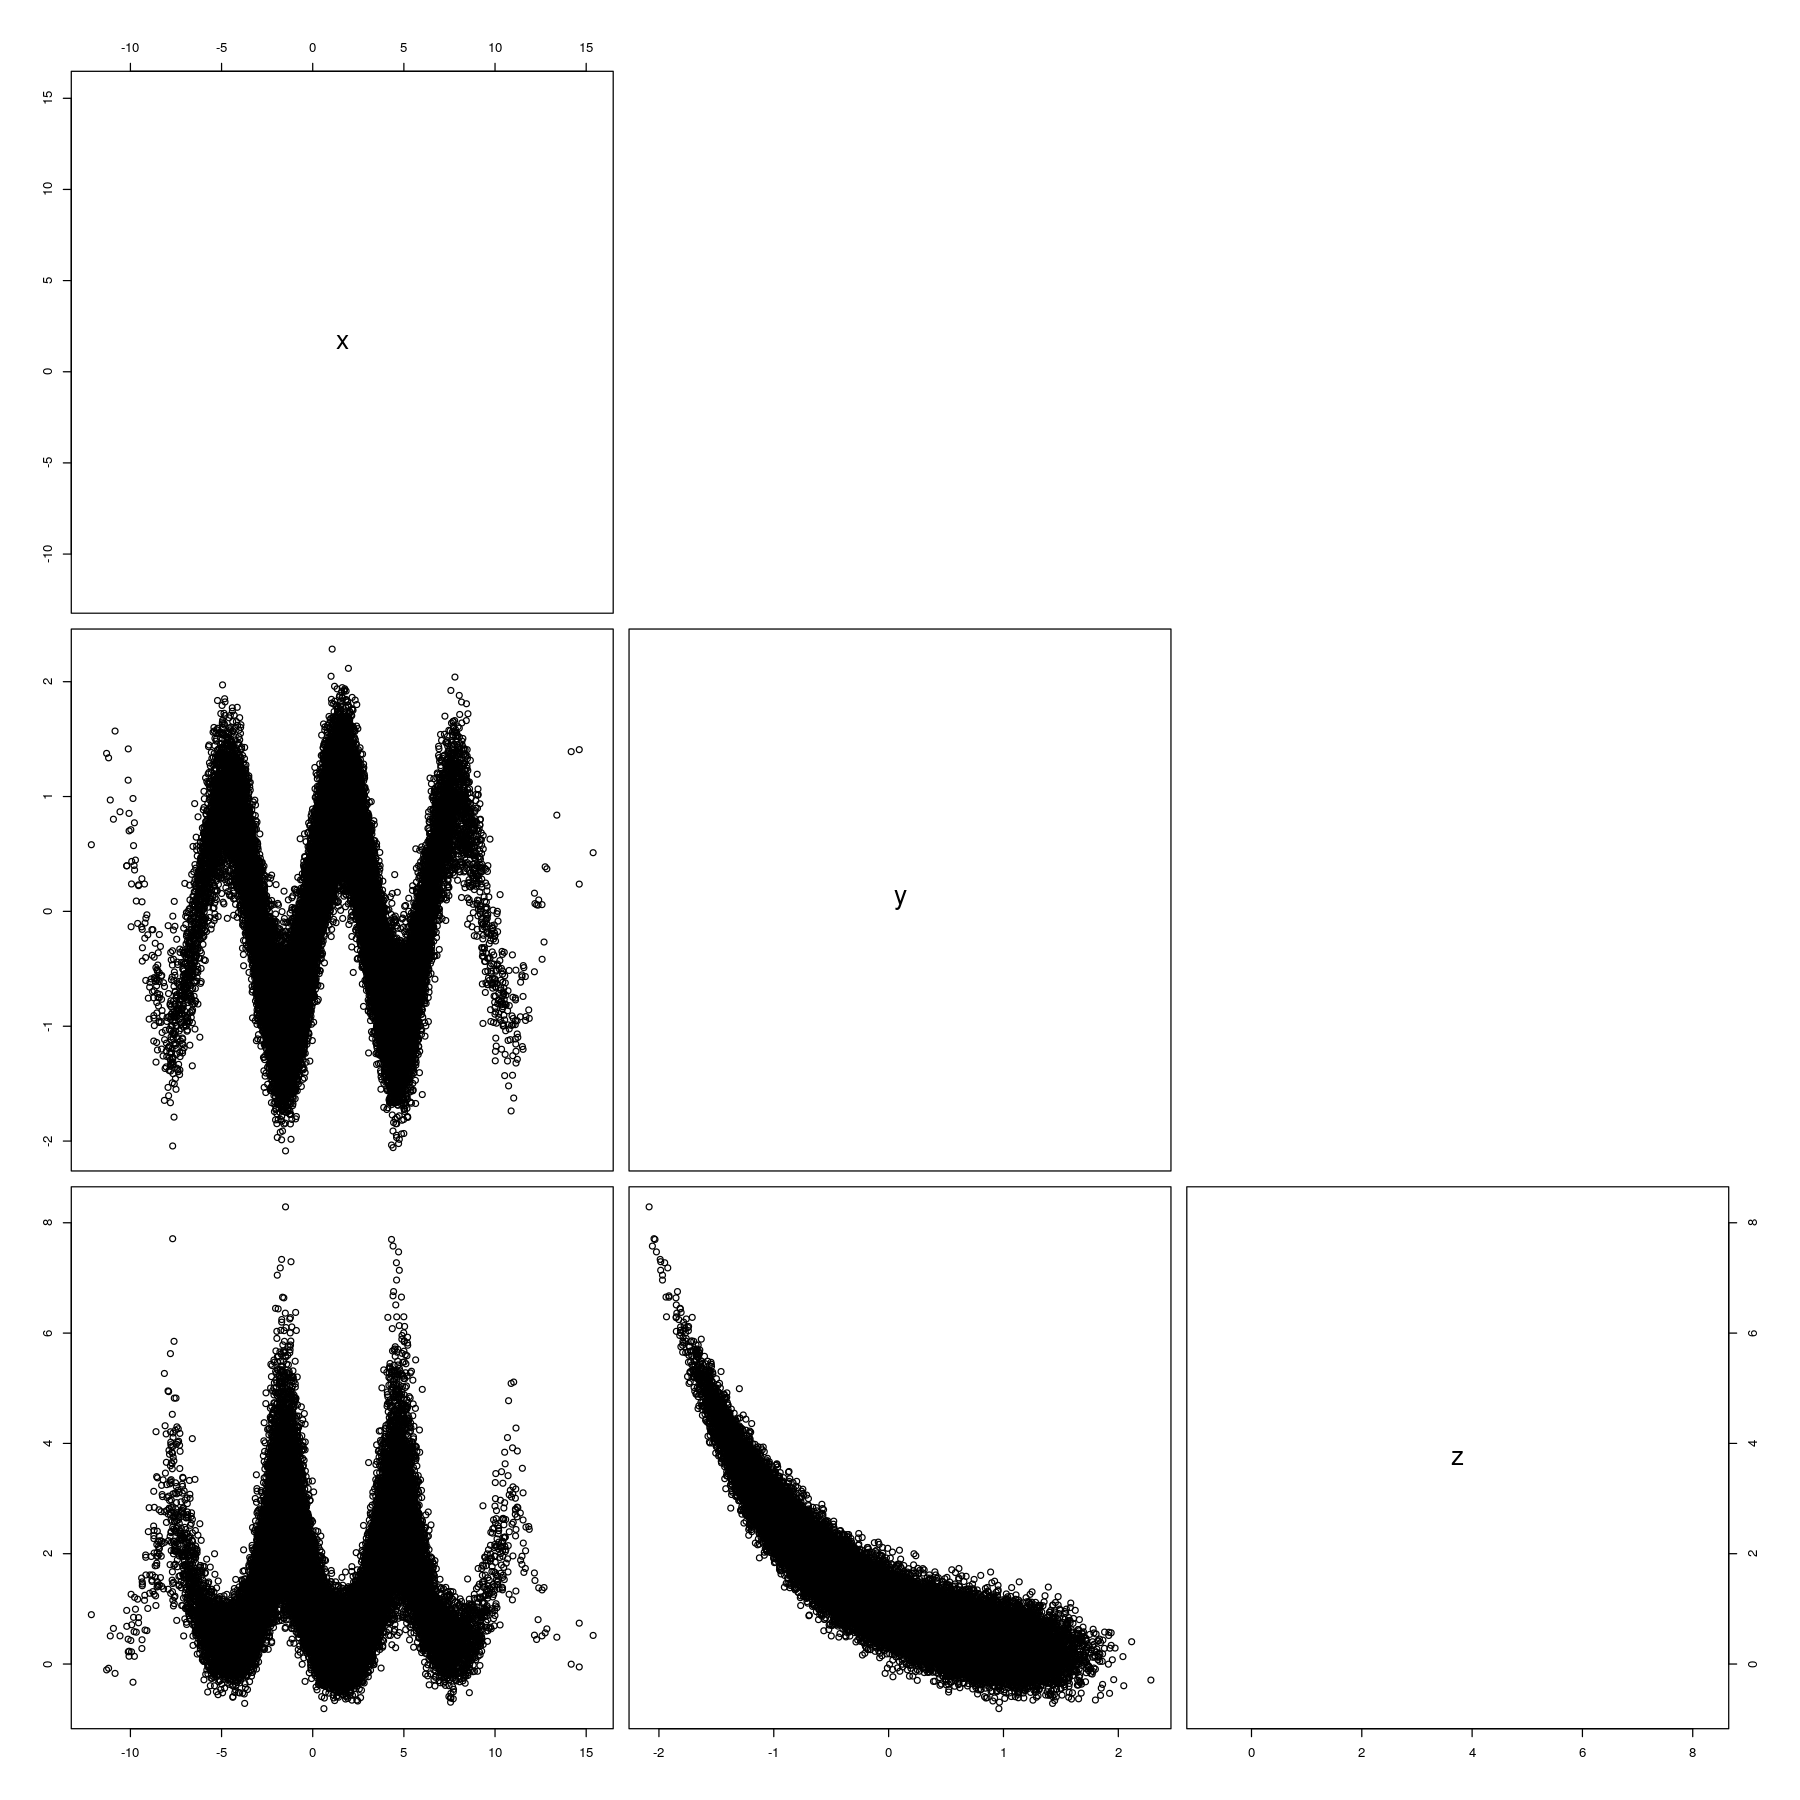

In [59]:
n=5e+4
a=1/20
b=100/20
mu=1

x=rnorm(n, mu, 1/sqrt(2*a))
y=rnorm(n, sin(x), 1/sqrt(2*b))
z=rnorm(n, exp(-y), 1/sqrt(2*b))


pairs(cbind(x,y,z), upper.panel=NULL)

While *pairs()* does not show the elevation of the distribution, the function *ipairs()* from the package **IDPmisc** plots proper 2d histograms with user given bin size, and shows the elevation with colour.

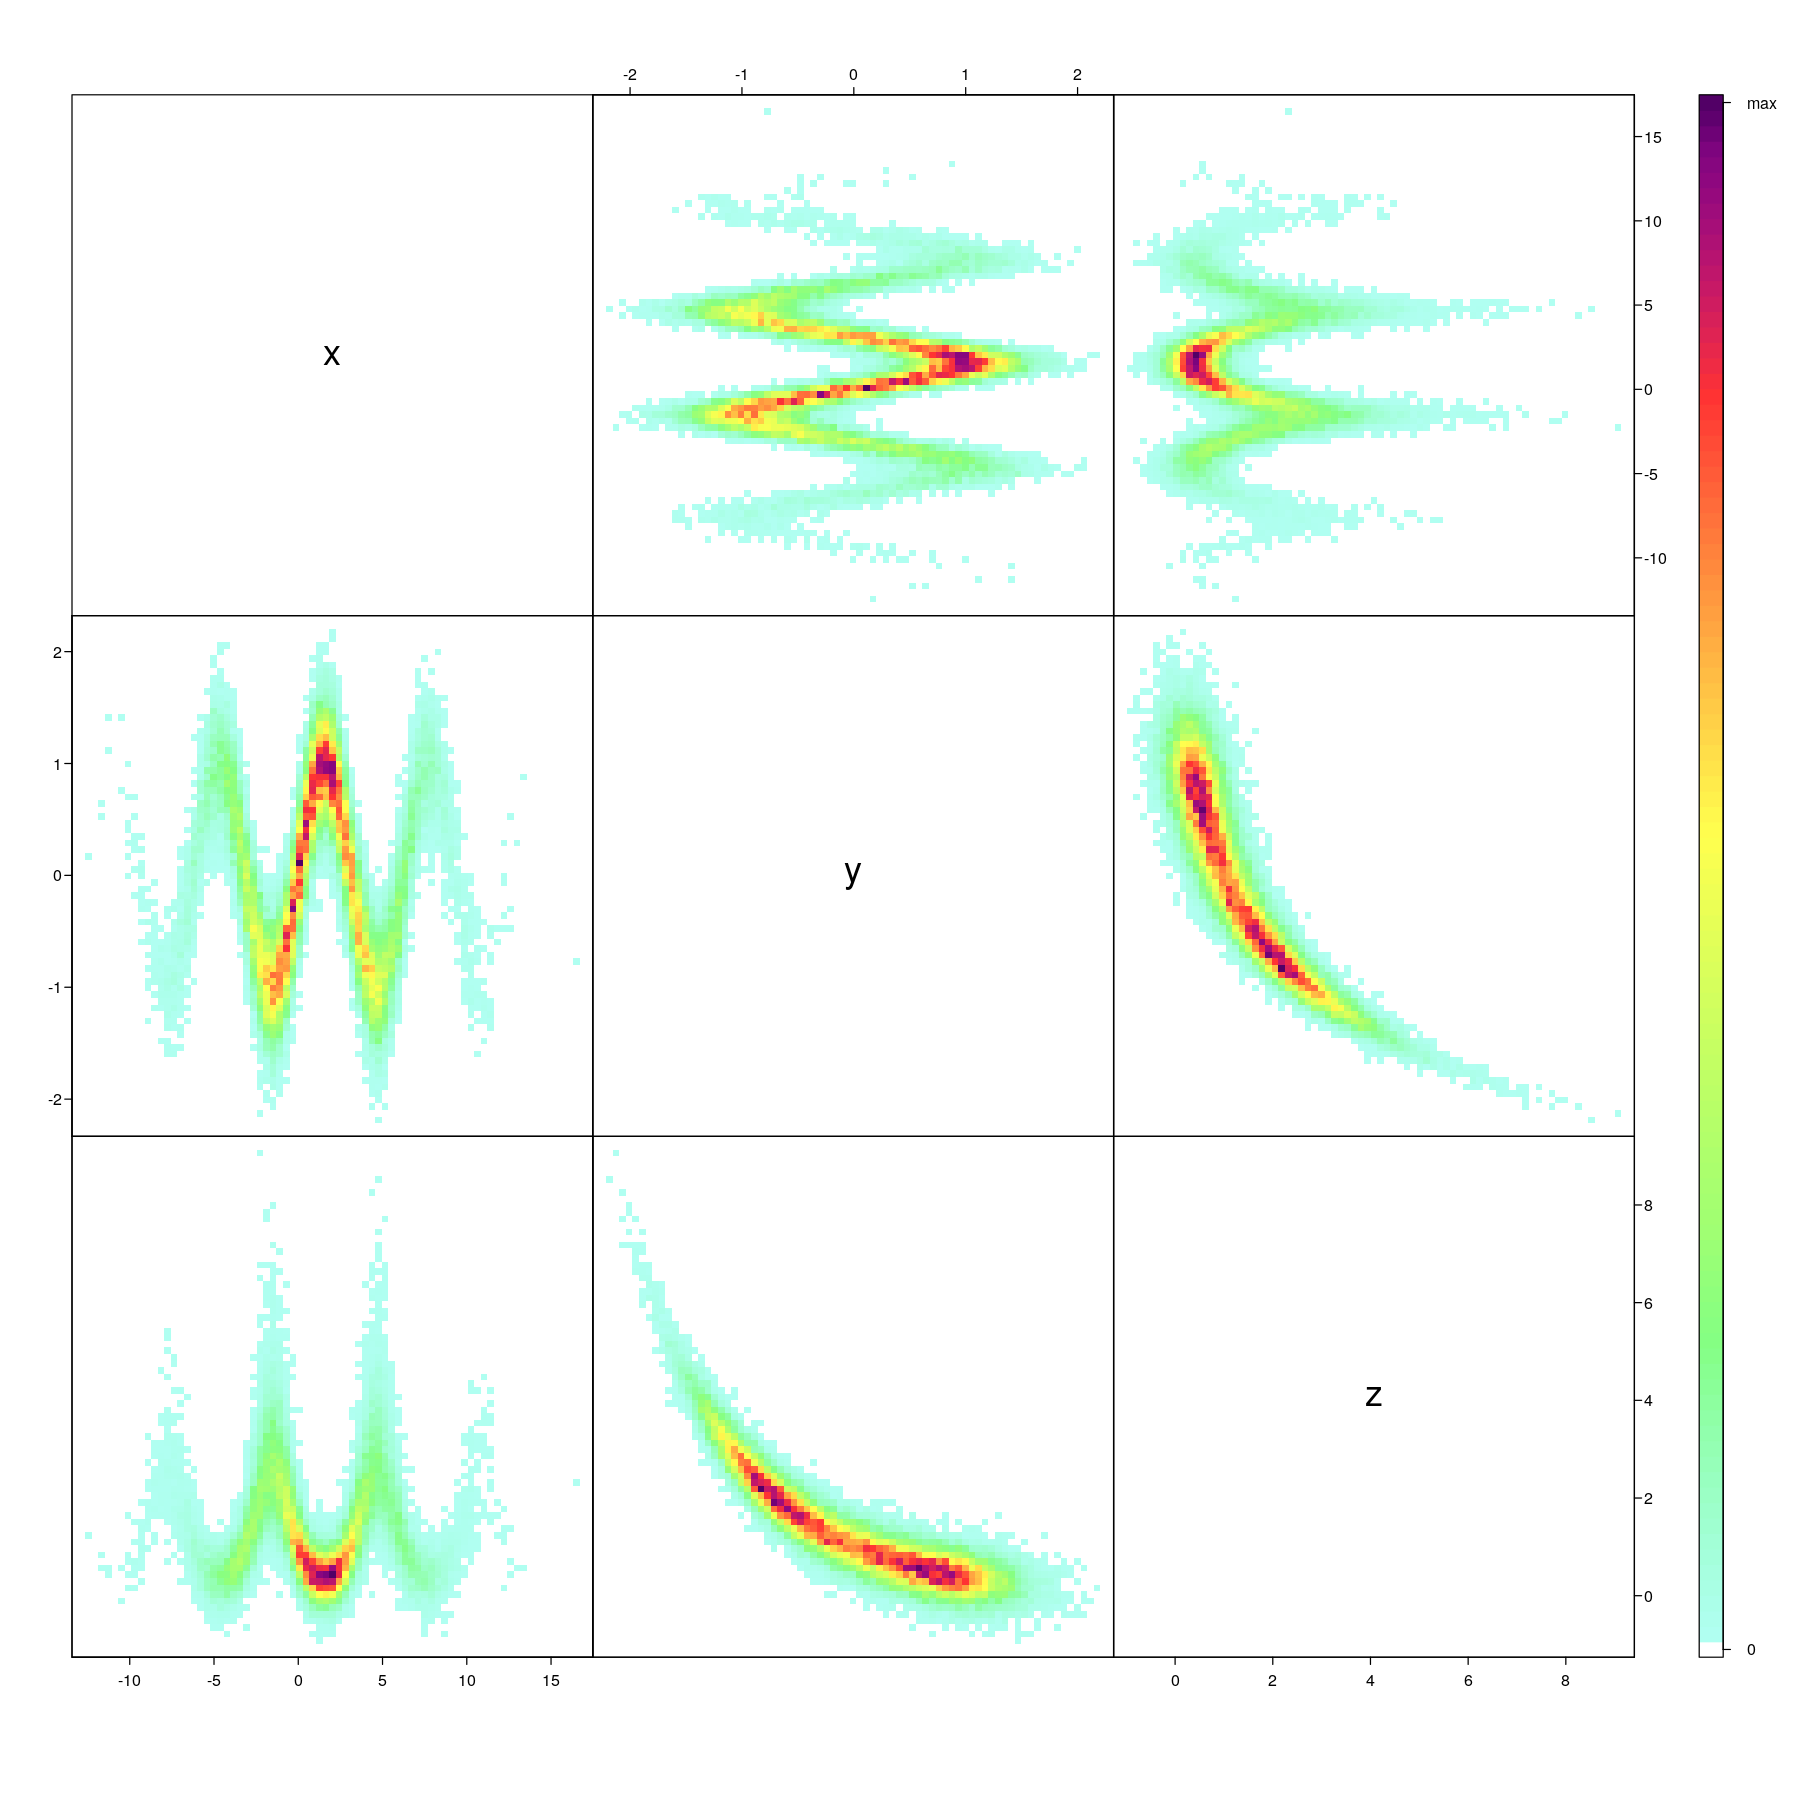

In [44]:
ipairs(cbind(x,y,z), pixs=.5)

The following is what I tend to use.

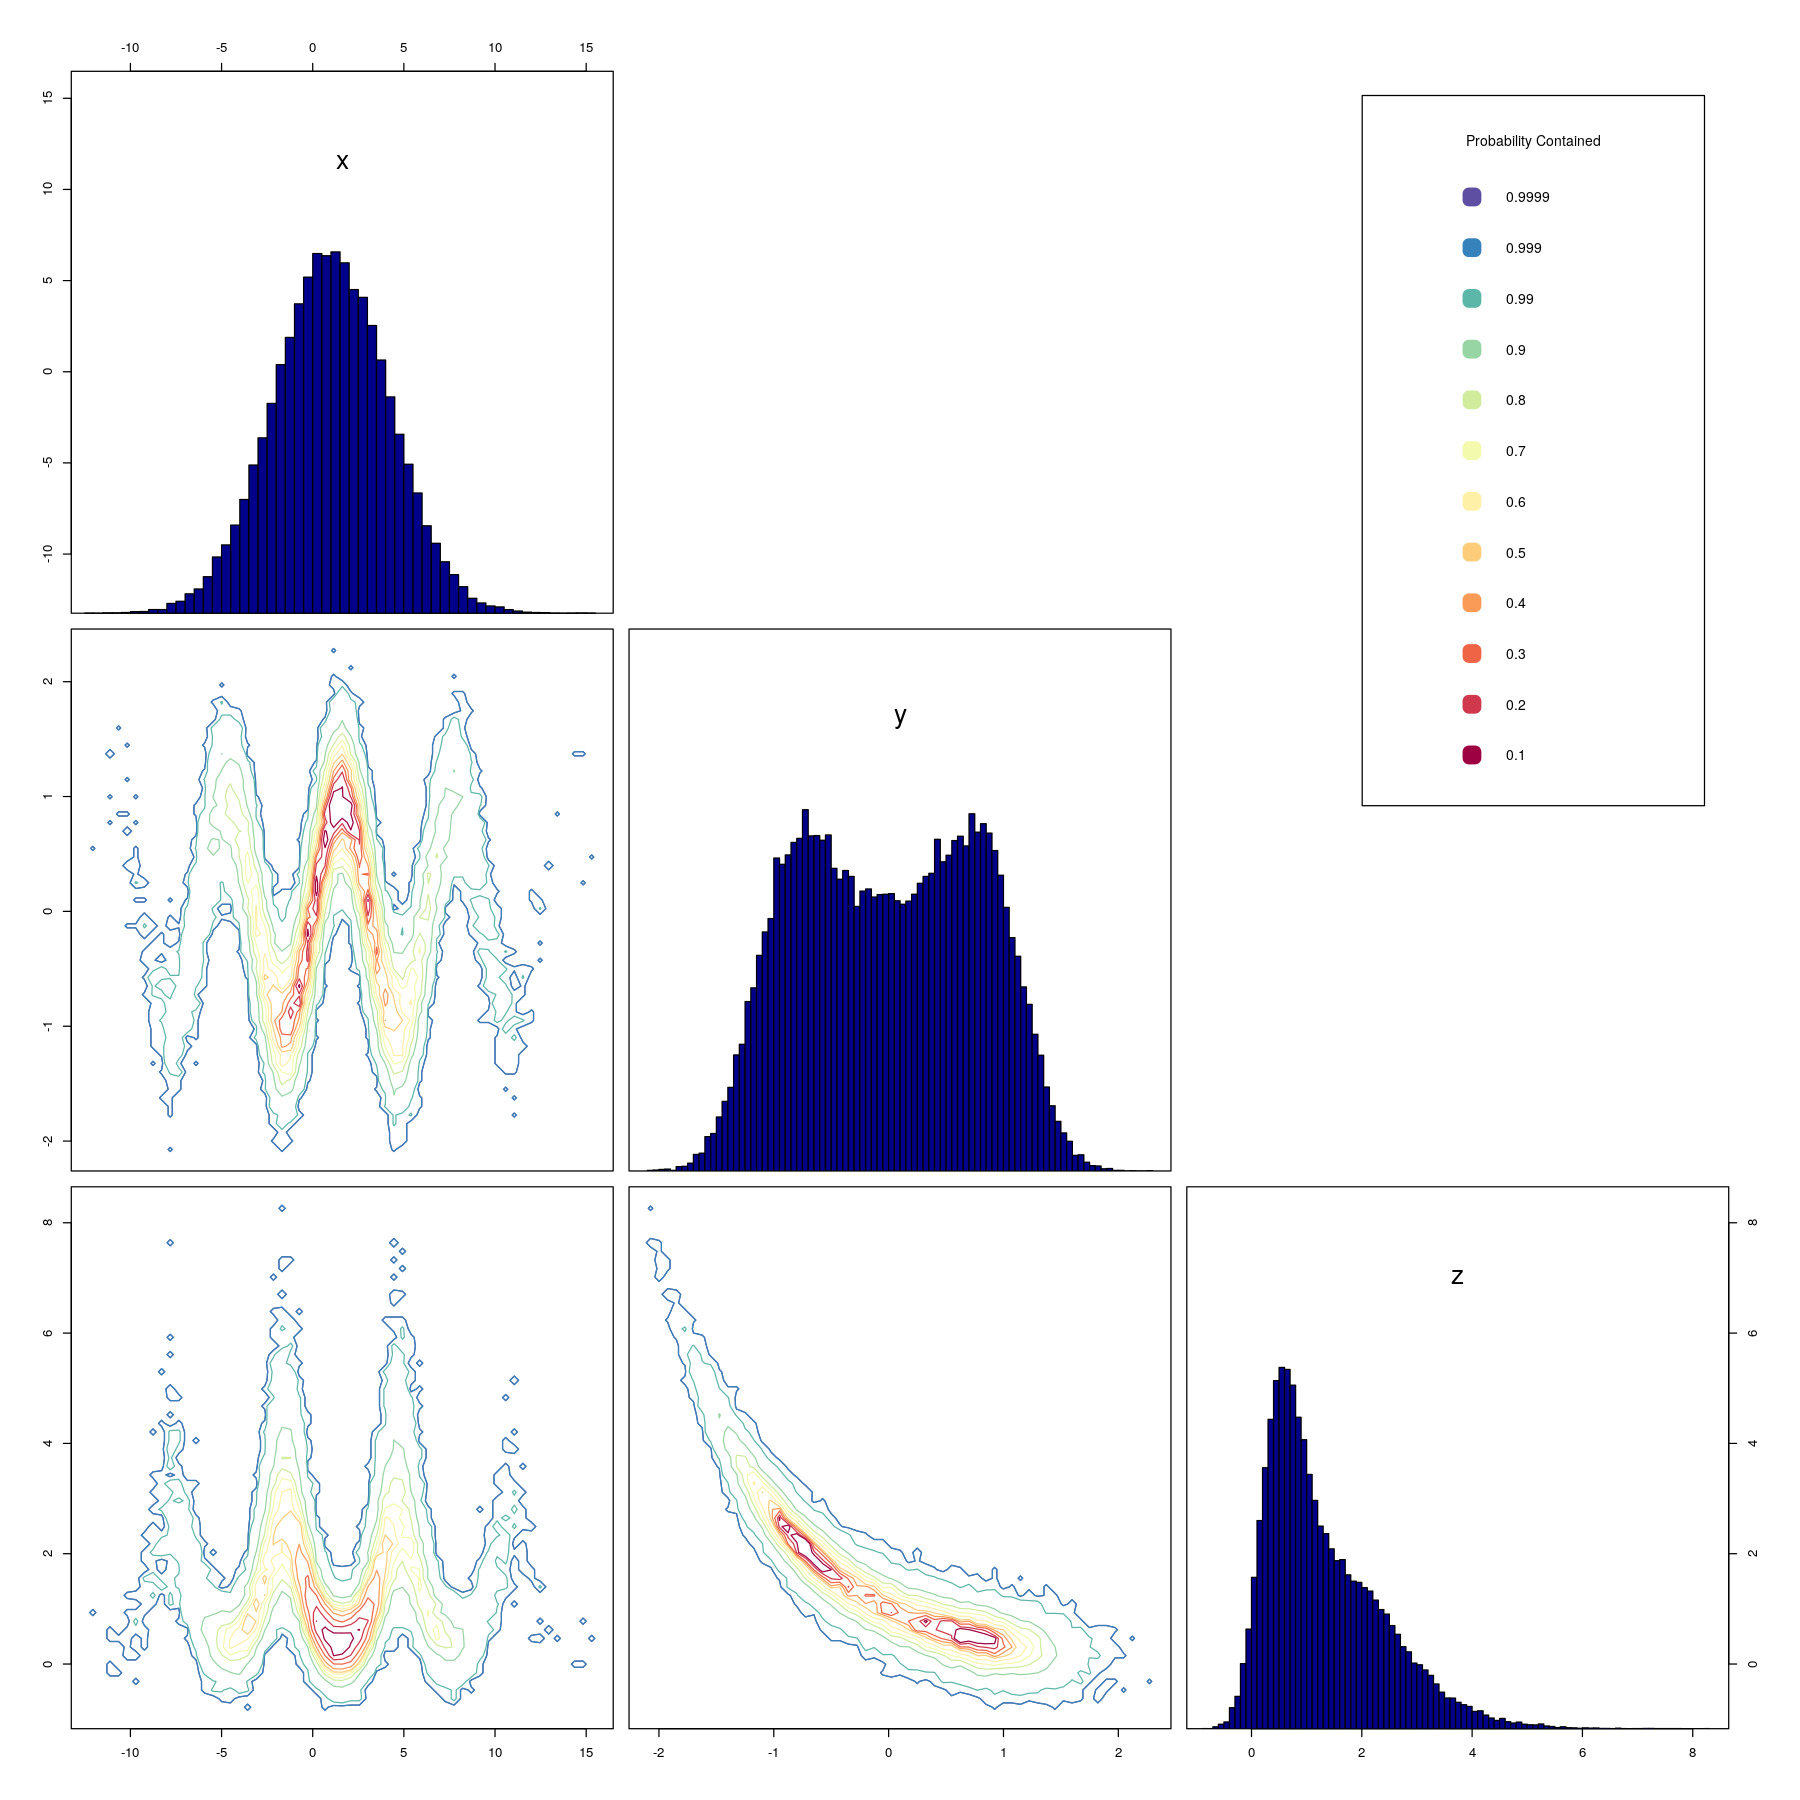

In [61]:
library(IDPmisc)

panel.hist2 <- function(x, ...)
{
	usr <- par("usr"); on.exit(par(usr))
	par(usr = c(usr[1:2], 0, 1.5) )
	h <- hist(x, plot = FALSE)
	breaks <- h$breaks; nB <- length(breaks)
	
	h <- hist(x, breaks = nB*4, plot = FALSE) #use 4 times the breaks!!!!!!!!
	breaks <- h$breaks; nB <- length(breaks)
	y <- h$counts; y <- y/max(y)
	rect(breaks[-nB], 0, breaks[-1], y, col="blue4", ...)
	#axis(1, tick=F, line=-1)
	#axis(1, labels=F, lwd=.5)
}

myBetterPairs <- function(YourData, resol=1, lab=NULL){ #label, conf_contour2,  no upper panel
	if ( is.null(lab) ){
		return(pairs(YourData, lower.panel=function(...) {par(new=TRUE); conf_contour2(histMat <- myImage(matrix(c(...),dim(YourData)[1],2), pixs=resol, matrix = T), alpha=clevels, cl=r, lab=F, add = T)}, diag.panel=panel.hist2, upper.panel=NULL))
	} else {
		return(pairs(YourData, lower.panel=function(...) {par(new=TRUE); conf_contour2(histMat <- myImage(matrix(c(...),dim(YourData)[1],2), pixs=resol, matrix = T), alpha=clevels, cl=r, lab=F, add = T)}, diag.panel=panel.hist2, upper.panel=NULL, labels = lab))
	}
}

myImage = function (x, y = NULL, pixs = 1, zmax = NULL, ztransf = function(x) {x}, colramp = IDPcolorRamp, factors = c(FALSE, FALSE), matrix = FALSE) 
{
	## function hacked from IDPmisc, as I needed the values and not the histogram ##
	library(plotly)
	library(pracma)
	
    xy <- NaRV.omit(getXY(x, y))
    factors <- factors | sapply(xy, is.factor)
    xy <- sapply(xy, as.numeric)
    pixs <- (pixs/10)/2.54
    usr <- par("usr")
    if (factors[1]) {
        bx <- seq(min(xy[, 1] - 0.25), max(xy[, 1] + 0.25), length.out = 2 * diff(range(xy[, 1])) + 2) #bx and by are bins!
    }
    else {
        bx <- seq(usr[1], usr[2], length.out = round(par("pin")/pixs)[1] + 1)
    }
    if (factors[2]) {
        by <- seq(min(xy[, 2] - 0.25), max(xy[, 2] + 0.25), length.out = 2 * diff(range(xy[, 2])) + 2)
    }
    else {
        by <- seq(usr[3], usr[4], length.out = round(par("pin")/pixs)[2] + 1)
    }
    zz <- ztransf(table(cut(xy[, 1], breaks = bx), cut(xy[, 2], breaks = by)))
    zzmax <- ceiling(max(zz))
    if (is.null(zmax)) zmax <- zzmax
    else zmax <- ceiling(zmax)
    if (zmax < 1 || is.null(zmax)) {stop("zmax must be >= 1 and\n          plot(x,y,...) must have been called before calling this function!\n")}
    if (zzmax > zmax) stop("zmax too small! Densiest aereas are out of range!", call. = FALSE)
    zmax <- max(zmax, 2)
    lbx <- length(bx)
    lby <- length(by)
    xx <- 0.5 * (bx[-1] + bx[-lbx])
    yy <- 0.5 * (by[-1] + by[-lby])
    #image(x = xx, y = yy, zz, col = colramp(zmax), breaks = seq(0.5, zmax + 1, 1), xaxs = "r", yaxs = "r", add = TRUE)
    #box()
    if (matrix) invisible(list(xx,yy,zz,bx,by)) ######outputs list with bins as well
    else invisible(zzmax)
}

conf_contour2 = function(hist2d_obj, alpha, normalise=F, add=F, cl="black", lab=T, Xlim, Ylim) { #flattest, not edge
	## based on drawcontour.R, written by J.D. Forester, 17 March 2008 ##
	znorm <- hist2d_obj[[3]] / ifelse(normalise,sum(hist2d_obj[[3]]),1)
	zdens <- sort(znorm, decreasing=T)
	Czdens <- cumsum(zdens)
	Czdens <- (Czdens/Czdens[length(zdens)]) #normalise levels

	for(cont.level in 1:length(alpha)){
		tmpp = max(which(Czdens<=alpha[cont.level]))
		if( is.infinite(tmpp) ) {
			cat("skipped level",alpha[cont.level],"\n", sep=" ")
			next
		}
    	crit.val <- zdens[tmpp]
    	contour(x=hist2d_obj[[1]], y=hist2d_obj[[2]], z=znorm, levels = crit.val, add=ifelse(add,T,ifelse(cont.level==1,F,T) ), method="flattest", labels = alpha[cont.level], drawlabels = lab, col = cl[cont.level], xlim=Xlim, ylim=Ylim) #edge

	}
}

## Build color palette ##
library(RColorBrewer)
library(colorRamps)

clevels = c(.9999, .999, .99, seq(.9, .1, by=-.1) )

l = length(clevels)
rf <- colorRampPalette(rev(brewer.pal(11,'Spectral')))
#r <- rf(length(pretty(range(histMat[[3]])/sum(histMat[[3]]),l )))
r <- rf(l)
        
        
## Actually do the plot ##
myBetterPairs(cbind(x,y,z), resol=.7 ) #resol=.02

par(xpd=TRUE)
legend("topright", border=r, legend = clevels, horiz = F, pt.lwd=10, col=r, pch=0, cex = .7, inset=.04, title="Probability Contained") #inset=.048
par(xpd=FALSE)
        
#the numbers are a bit small here in jupyter, but are fine in normal R.

Note how the plots show contours constructed by taking the flattest line going through the bins of the 2d histograms. Using basic KDE without checking its assumptions (which in this case are very much not satisfied) may lead to very wrong pictures. Using contours based on histograms gives lines that are not as smooth as one may want, but it's easier to tell when they're over-smoothed. Talk to me if you want to know more about this.

## 2) Basic MCMC on a 2d Rosenbrock

We're now going to take a sample from a 2d Rosenbrock distribution using a Random Walk Metropolis (RWM) algorithm. 

Change the shape of the distribution by changing the parameters *mu, a, b*. Remember to look at the scales of the distribution on the side of the graph, to get a sense of how long the tails are.

Tune the RWM algorithm by changing the step size, to obtain an acceptance of maybe 23-35%. The optimal acceptance is usually around 41% for a one dimensional target, and 23.4% for an infinite dimensional one.

Change the *resol* argument in the function *myBetterPairs()* to get a feeling of what value does not over-smooth nor under-smooth the density.

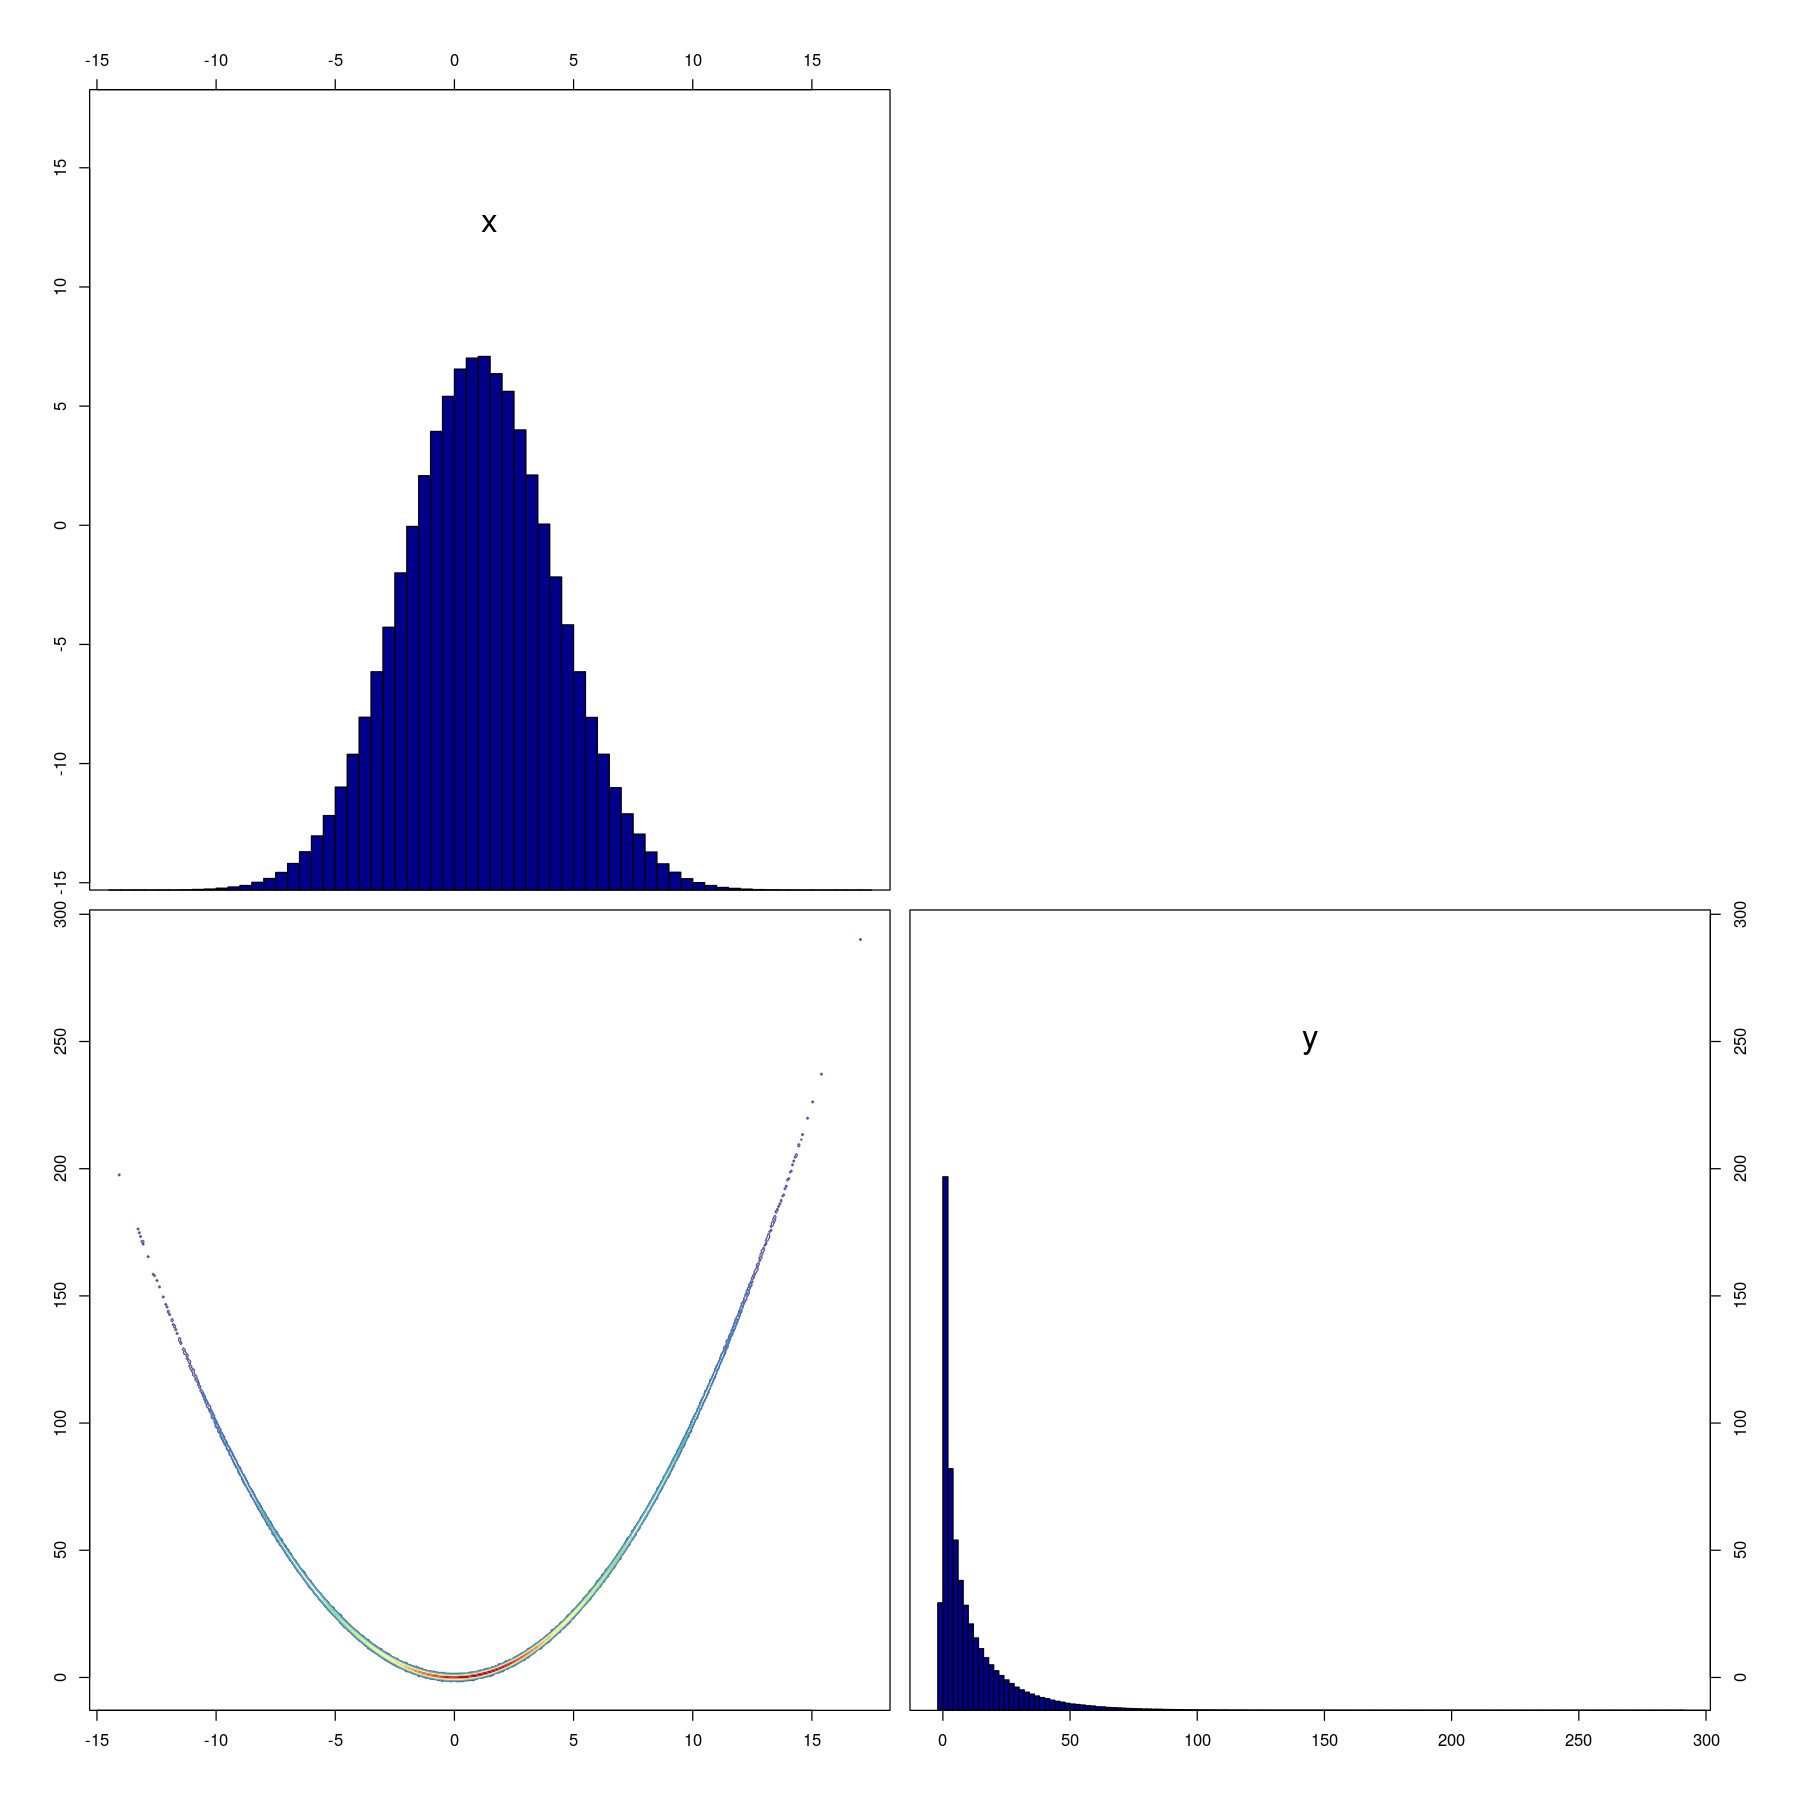

In [52]:
#### What the *true* distribution looks like ####

n=1e+6     #number of random iid Monte Carlo samples. Increase if histograms are too jagged. Not too much!
mu=1       #position of the mode along the parabola x^2
a=1/20     #variation *along* the parabola x^2
b=100/20   #variation *around* the parabola x^2

x=rnorm(n, mu, 1/sqrt(2*a)) #draw iid MC samples
y=rnorm(n, x^2, 1/sqrt(2*b))

myBetterPairs(cbind(x,y), resol=.1 ) #plot. Careful not to under- or over-smooth.

Tot run = N*thin =  1e+06 
Progress: 10 % 
Progress: 20 % 
Progress: 30 % 
Progress: 40 % 
Progress: 50 % 
Progress: 60 % 
Progress: 70 % 
Progress: 80 % 
Progress: 90 % 
Progress: 100 % 
Run Time 0.1 Min 
Acc Rate 0.295554 


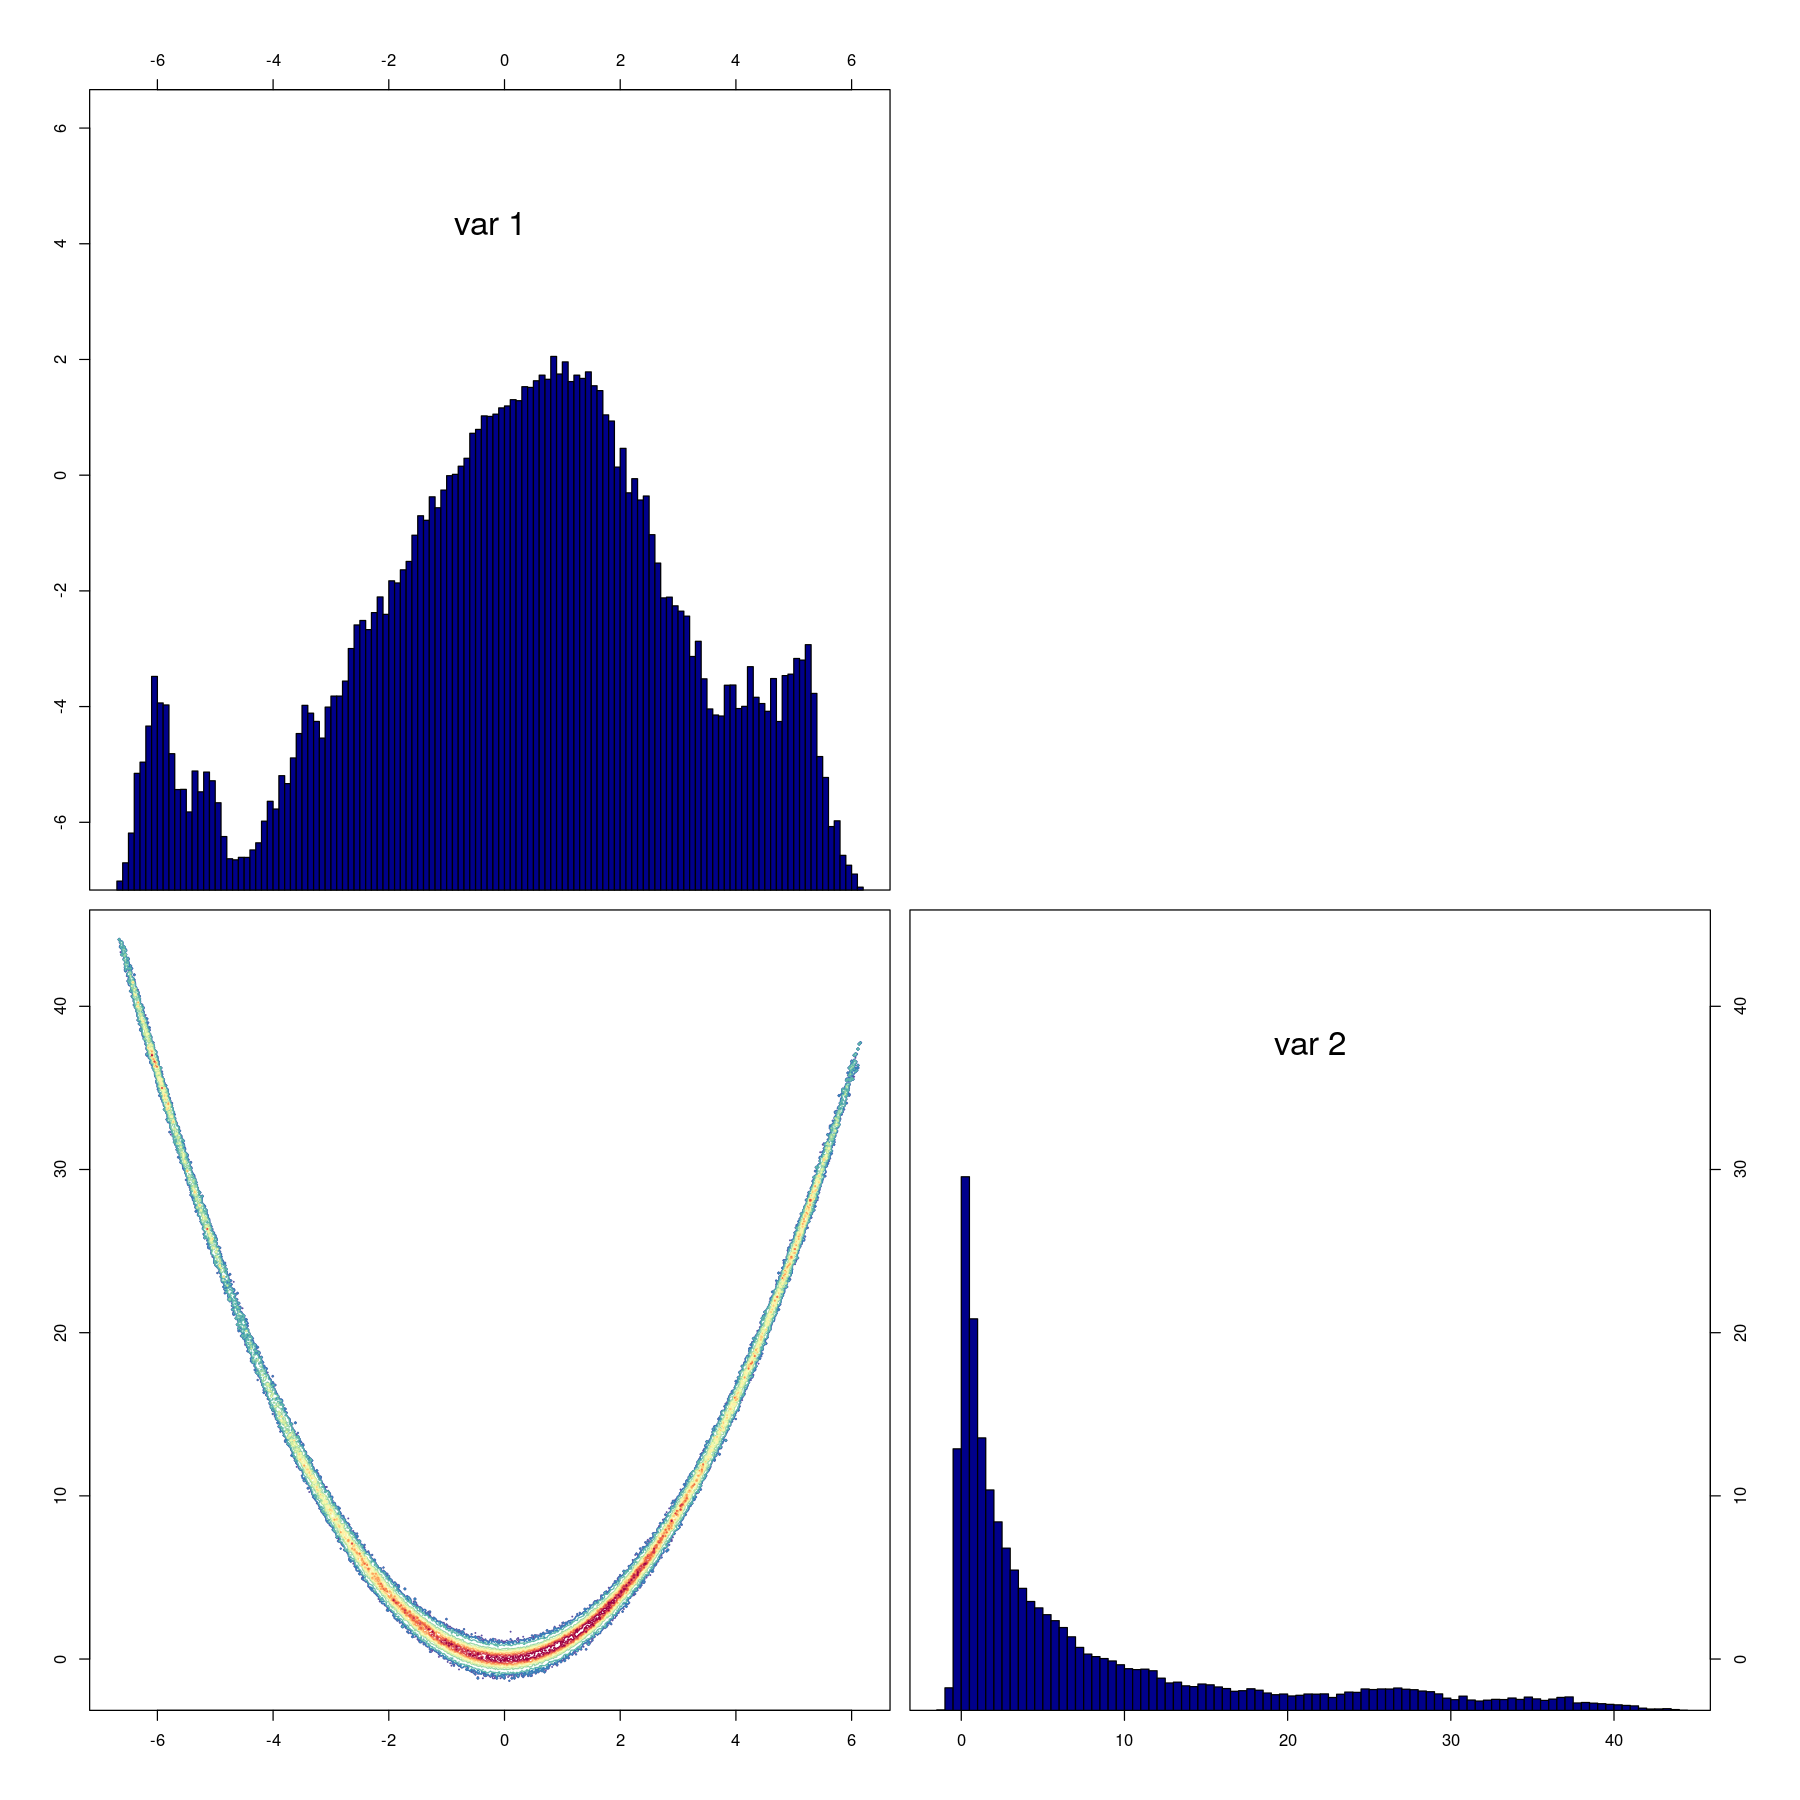

In [57]:
#### run a RWM and compare the plot below to the one above ####


rw <- function(target, N, x, step, Sigma=diag(length(x)), thin=1)
{
ptm=proc.time()
cat("Tot run = N*thin = ",N*thin,"\n")
if ( sum(Sigma - diag(length(x)) )==0  ){
	ident=TRUE
} else {
	ident=FALSE
	Sigma.chol <- t( chol(Sigma) )
}
dd=length(x) 
acc=0
samples = matrix(0, N, length(x) )
samples[1,] <- x
run=N*thin
target_prop = target_x = target(x)
for (i in 2:run )
{
	if(i%%(run/10)==0) cat("Progress:",i/run*100,"% \n") #track progress
	
	if (ident) prop <- x + step*rnorm(dd)
	else prop = x + step * Sigma.chol %*% rnorm(dd)
	
	target_prop = target(prop)

	if (runif(1) < exp( target_prop - target_x ) ){
		x <- prop
		acc = acc + 1
		target_x = target_prop
	}
	
	if( (i%%thin)==0 ) samples[i/thin,] = x
}
time=proc.time()-ptm
cat('Run Time',round(time[1]/60,digits=2),'Min','\n')
cat("Acc Rate",acc/run,"\n")
#system(paste("echo Acc",acc/run))
return(list(samples,time[1]))
}

        
logTarget1=function(q){-a*(q[1]-mu)^2 -b*(q[2] - q[1]^2)^2 } #careful: parameter values mu, a, b defined in the cell above
resRW=rw(logTarget1, 1e+6, c(1,1), .4) #try increasing the n. of MCMC samples (2nd argument) to improve the plot. Not too much!
        
myBetterPairs(resRW[[1]], resol=.1 ) #plot. Careful not to under- or over-smooth.
        
#the keen ones can try to see if a rotation matrix and thinning help at all. See arguments of rw() function.

## 3) Basic MCMC on a 5d Hybrid Rosenbrock

Warning message in max(which(Czdens <= alpha[cont.level])):
“no non-missing arguments to max; returning -Inf”


skipped level 0.1 


Warning message in max(which(Czdens <= alpha[cont.level])):
“no non-missing arguments to max; returning -Inf”


skipped level 0.1 


Warning message in max(which(Czdens <= alpha[cont.level])):
“no non-missing arguments to max; returning -Inf”


skipped level 0.1 


Warning message in max(which(Czdens <= alpha[cont.level])):
“no non-missing arguments to max; returning -Inf”


skipped level 0.1 


Warning message in max(which(Czdens <= alpha[cont.level])):
“no non-missing arguments to max; returning -Inf”


skipped level 0.7 


Warning message in max(which(Czdens <= alpha[cont.level])):
“no non-missing arguments to max; returning -Inf”


skipped level 0.6 


Warning message in max(which(Czdens <= alpha[cont.level])):
“no non-missing arguments to max; returning -Inf”


skipped level 0.5 


Warning message in max(which(Czdens <= alpha[cont.level])):
“no non-missing arguments to max; returning -Inf”


skipped level 0.4 


Warning message in max(which(Czdens <= alpha[cont.level])):
“no non-missing arguments to max; returning -Inf”


skipped level 0.3 


Warning message in max(which(Czdens <= alpha[cont.level])):
“no non-missing arguments to max; returning -Inf”


skipped level 0.2 


Warning message in max(which(Czdens <= alpha[cont.level])):
“no non-missing arguments to max; returning -Inf”


skipped level 0.1 


Warning message in max(which(Czdens <= alpha[cont.level])):
“no non-missing arguments to max; returning -Inf”


skipped level 0.1 


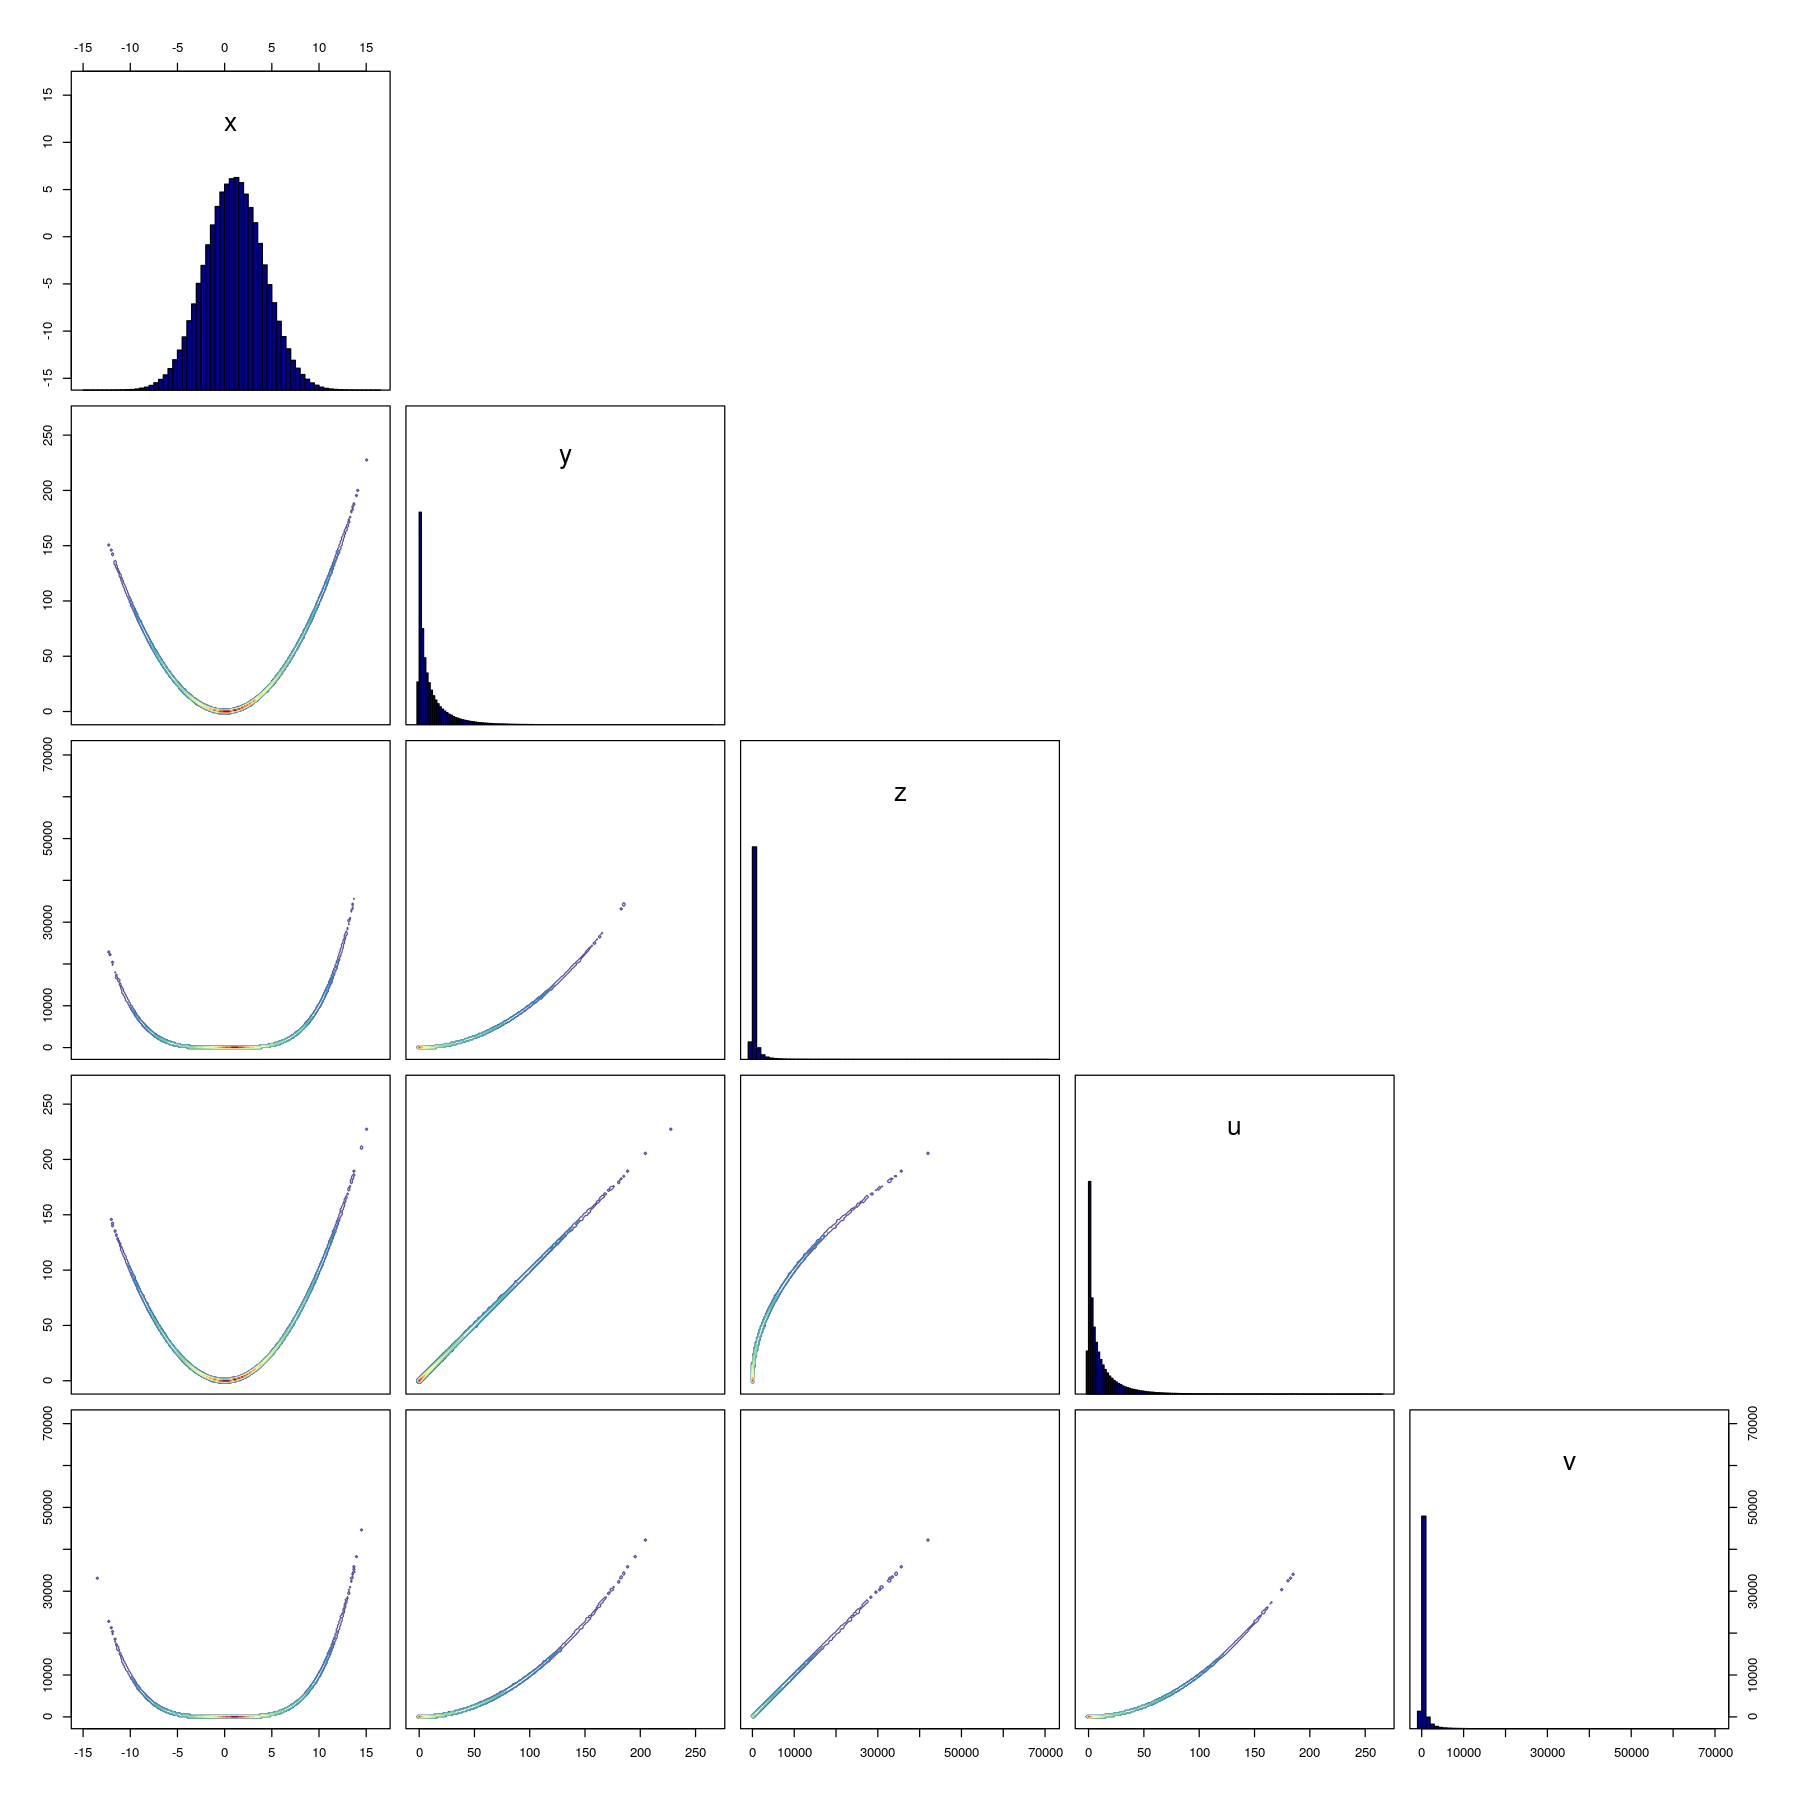

In [62]:
#### What the *true* distribution looks like ####

n=1e+6     #number of random iid Monte Carlo samples. Increase if histograms are too jagged. Not too much!
mu=1       #position of the mode along the parabola x^2
a=1/20     #variation *along* the parabola x^2
c=b=100/20   #variation *around* the parabola x^2

x=rnorm(n, mu, 1/sqrt(2*a)) #draw iid MC samples
y=rnorm(n, x^2, 1/sqrt(2*b))
z=rnorm(n, y^2, 1/sqrt(2*c))
u=rnorm(n, x^2, 1/sqrt(2*b))
v=rnorm(n, u^2, 1/sqrt(2*c))

myBetterPairs(cbind(x,y,z,u,v), resol=.1 ) #plot. Careful not to under- or over-smooth.

#don't mind the warnings, you're just skipping to plot a contour line because it's too narrow.

In [64]:
logTarget6=function(q){-a*(q[1]-mu)^2 -b*(q[2] - q[1]^2)^2 -b*(q[3] - q[2]^2)^2 -b*(q[4] - q[1]^2)^2 -b*(q[5] - q[4]^2)^2 } 
#careful: parameter values mu, a, b defined in the cell above
resRW=rw(logTarget6, 1e+6, matrix(1,5,1), .065) 
#try increasing the n. of MCMC samples (2nd argument) to improve the plot. Not too much!

Tot run = N*thin =  1e+06 
Progress: 10 % 
Progress: 20 % 
Progress: 30 % 
Progress: 40 % 
Progress: 50 % 
Progress: 60 % 
Progress: 70 % 
Progress: 80 % 
Progress: 90 % 
Progress: 100 % 
Run Time 0.11 Min 
Acc Rate 0.730126 


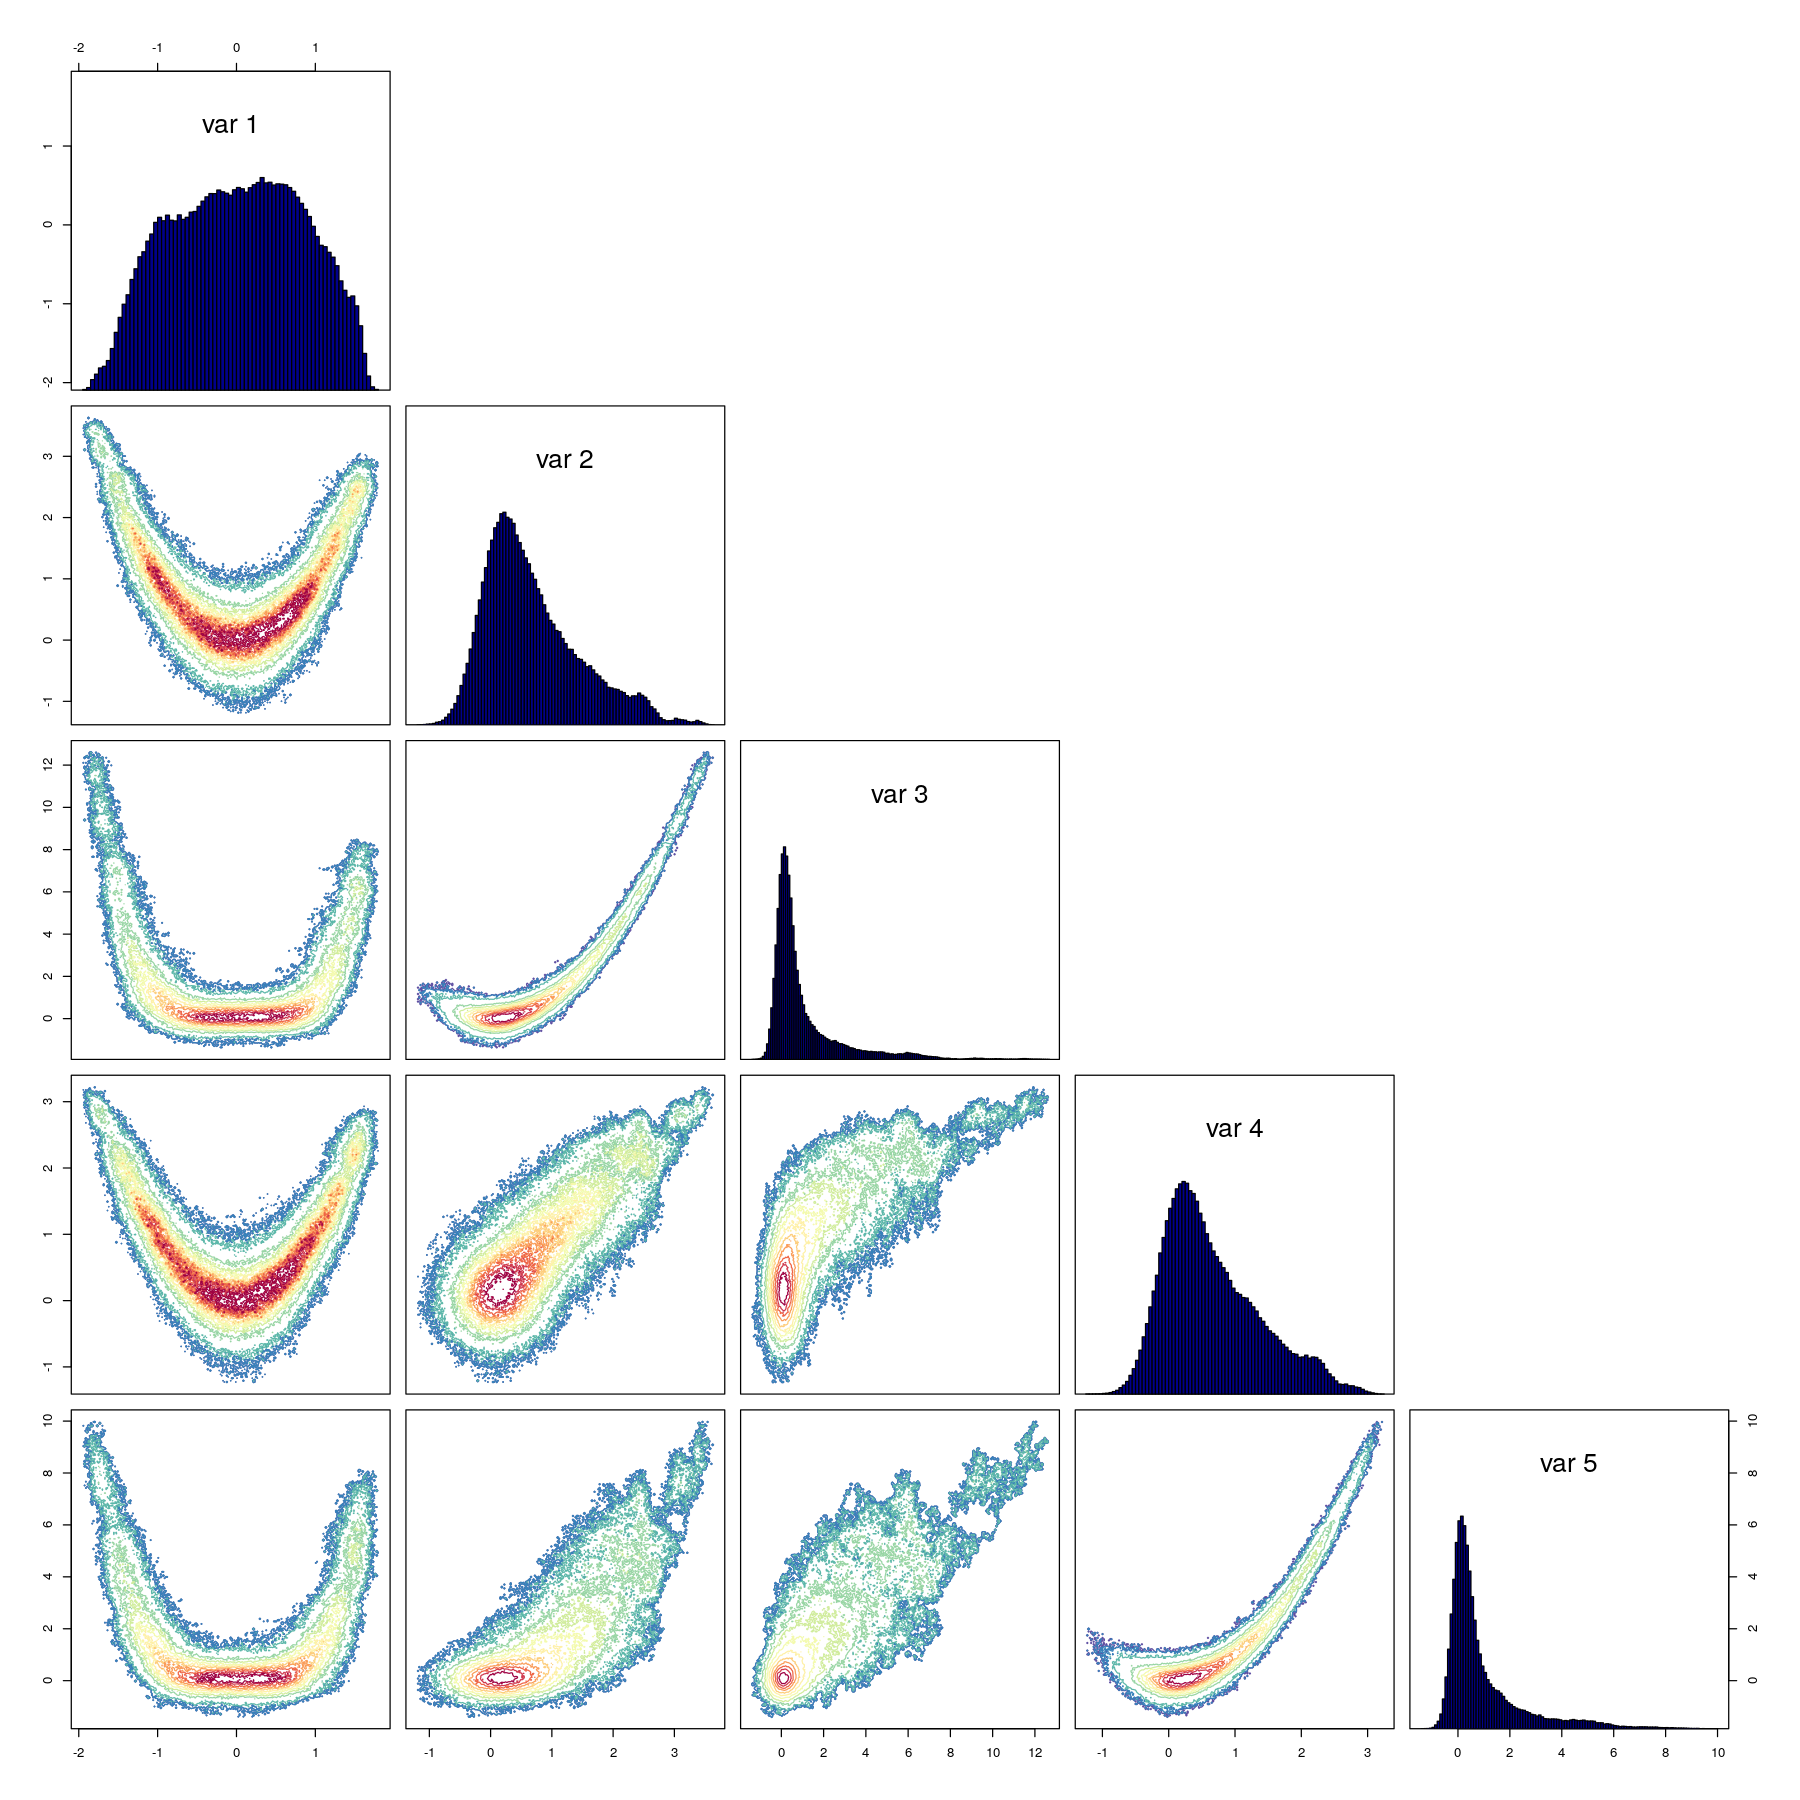

In [65]:
myBetterPairs(resRW[[1]], resol=.1 ) #plot. Careful not to under- or over-smooth.

It usually looks like it's doing ok (for a Random Walk), but actually it never really leaves the mode. How to realise that without knowing the solution? Run different, more sophisticated MCMC algorithms, such as Simplified Manifold MALA (sMMALA) and Stan (basically the NUTS algorithm) **IF** you can calculate the gradient and Hessian of your model.

## 4) Simplified Manifold MALA

sMMALA is a clever algorithm that uses the gradient of the target to inform its moves, as well as the local curvature. It's designed to be quite good on this kind of densities.

In [78]:
#### the sMMALA algorithm ####


malaSimplRosenGeneral=function(xi,h,run,alpha, U, gradU, H){
ptm=proc.time()
d=length(xi)

Heb=Hea=eigen(H(xi), symmetric = TRUE);
Lb=La=Hea$values * coth(alpha*Hea$values)
H2b=H2a=Hea$vectors %*% diag( 1/sqrt(La) ) #H^(-1/2)
H1b=H1a=H2a %*% t(H2a) #H^(-1)
H3b=H3a=Hea$vectors %*% diag( La ) %*% t(Hea$vectors) #H

meanGO = xi + h * H1a %*% gradU(xi)/2
meanBACK = 0 #declare vars outside loop ?
Uxi = U(xi)
Uxinew = 0

out=matrix(0,run,d)
count=0
for(n in 1:run){
	if(n%%(run/10)==0) { #track progress1
		cat("Progress:",n/run*100,"% \n") #cat("Iteration n.",n,"\n");
		#if(n==run/10){ time=proc.time()-ptm; cat("Estimated Run Time ",round(time[1]/60 /n*run ,digits=2),"Min","\n" );	}
	}
	
	xinew = meanGO + sqrt(h) * H2a %*% rnorm(d) #first iter const metric

	Heb=eigen(H(xinew), symmetric = TRUE);
	Lb=Heb$values * coth(alpha*Heb$values)
	H2b=Heb$vectors %*% diag( 1/sqrt(Lb) ) #H^-1/2
	H1b=H2b %*% t(H2b) #H^-1
	H3b=Heb$vectors %*% diag( Lb ) %*% t(Heb$vectors) #just H
	
	qlogGO  =1/2*sum(log(La)) - 1/(2*h) * t(xinew - meanGO) %*% H3a %*% (xinew - meanGO)
	
	meanBACK = xinew + h * H1b %*% gradU(xinew)/2
	qlogBACK=1/2*sum(log(Lb)) - 1/(2*h) * t(xi - meanBACK) %*% H3b %*% (xi - meanBACK)
	
	Uxinew=U(xinew)
	
	if( runif(1) < exp( Uxinew - qlogGO - Uxi + qlogBACK  ) ){ 
		xi=xinew
		count=count+1
		
		meanGO=meanBACK
		Uxi=Uxinew
		Hea=Heb
		La=Lb
		H2a=H2b
		H1a=H1b
		H3a=H3b
	}
	
	#if(n%%(run/10)==0) cat("Iteration n.",n,"\n") #track progress1
	out[n,]=xi
}
time=proc.time()-ptm
cat('Run Time',round(time[1]/60,digits=2),'Min','\n')
cat("Acc Rate",count/run,"\n")
#system(paste("echo Acc",count/run))
return(list(out,time[1]))
}


U6=function(q) {-a*(q[1]-mu)^2 -b*(q[2] - q[1]^2)^2 -b*(q[3] - q[2]^2)^2 -b*(q[4] - q[1]^2)^2 -b*(q[5] - q[4]^2)^2 } #U=+log
Dx6 = function(q) { 2*a*mu -8*b*q[1]^3 +q[1]*(-2*a + 4*b*q[2] +4*b*q[4]) }
Dy6 = function(q) { 2*b*(q[1]^2 +q[2]*(-1 -2*q[2]^2 +2*q[3]) ) }
Dz6 = function(q) { 2*b*(q[2]^2 -q[3]) }
Du6 = function(q) { 2*b*(q[1]^2 +q[4]*(-1 -2*q[4]^2 +2*q[5]) ) }
Dv6 = function(q) { 2*b*(q[4]^2 -q[5]) }
gradU6 = function(q) {c(Dx6(q), Dy6(q), Dz6(q), Du6(q), Dv6(q) )}
H6 = function(q) {-matrix(c(-2*a -24*b*q[1]^2 +4*b*q[2] +4*b*q[4], 4*b*q[1], 0, 4*b*q[1], 0,
							4*b*q[1], -2*b*(1 +6*q[2]^2 -2*q[3]), 4*b*q[2], 0, 0,
							0, 4*b*q[2], -2*b, 0, 0,
							4*b*q[1], 0, 0, -2*b*(1 +6*q[4]^2 -2*q[5]), 4*b*q[4],
							0, 0, 0, 4*b*q[4], -2*b) ,5,5, byrow = T)}



resMALA = malaSimplRosenGeneral(matrix(1,5,1), h=1.0, run=1e+5, 1e+6, U6, gradU6, H6)
#change h to maintain an acceptance of around 30%. There's no optima result here, it's just an indication.

Progress: 10 % 
Progress: 20 % 
Progress: 30 % 
Progress: 40 % 
Progress: 50 % 
Progress: 60 % 
Progress: 70 % 
Progress: 80 % 
Progress: 90 % 
Progress: 100 % 
Run Time 0.18 Min 
Acc Rate 0.31433 


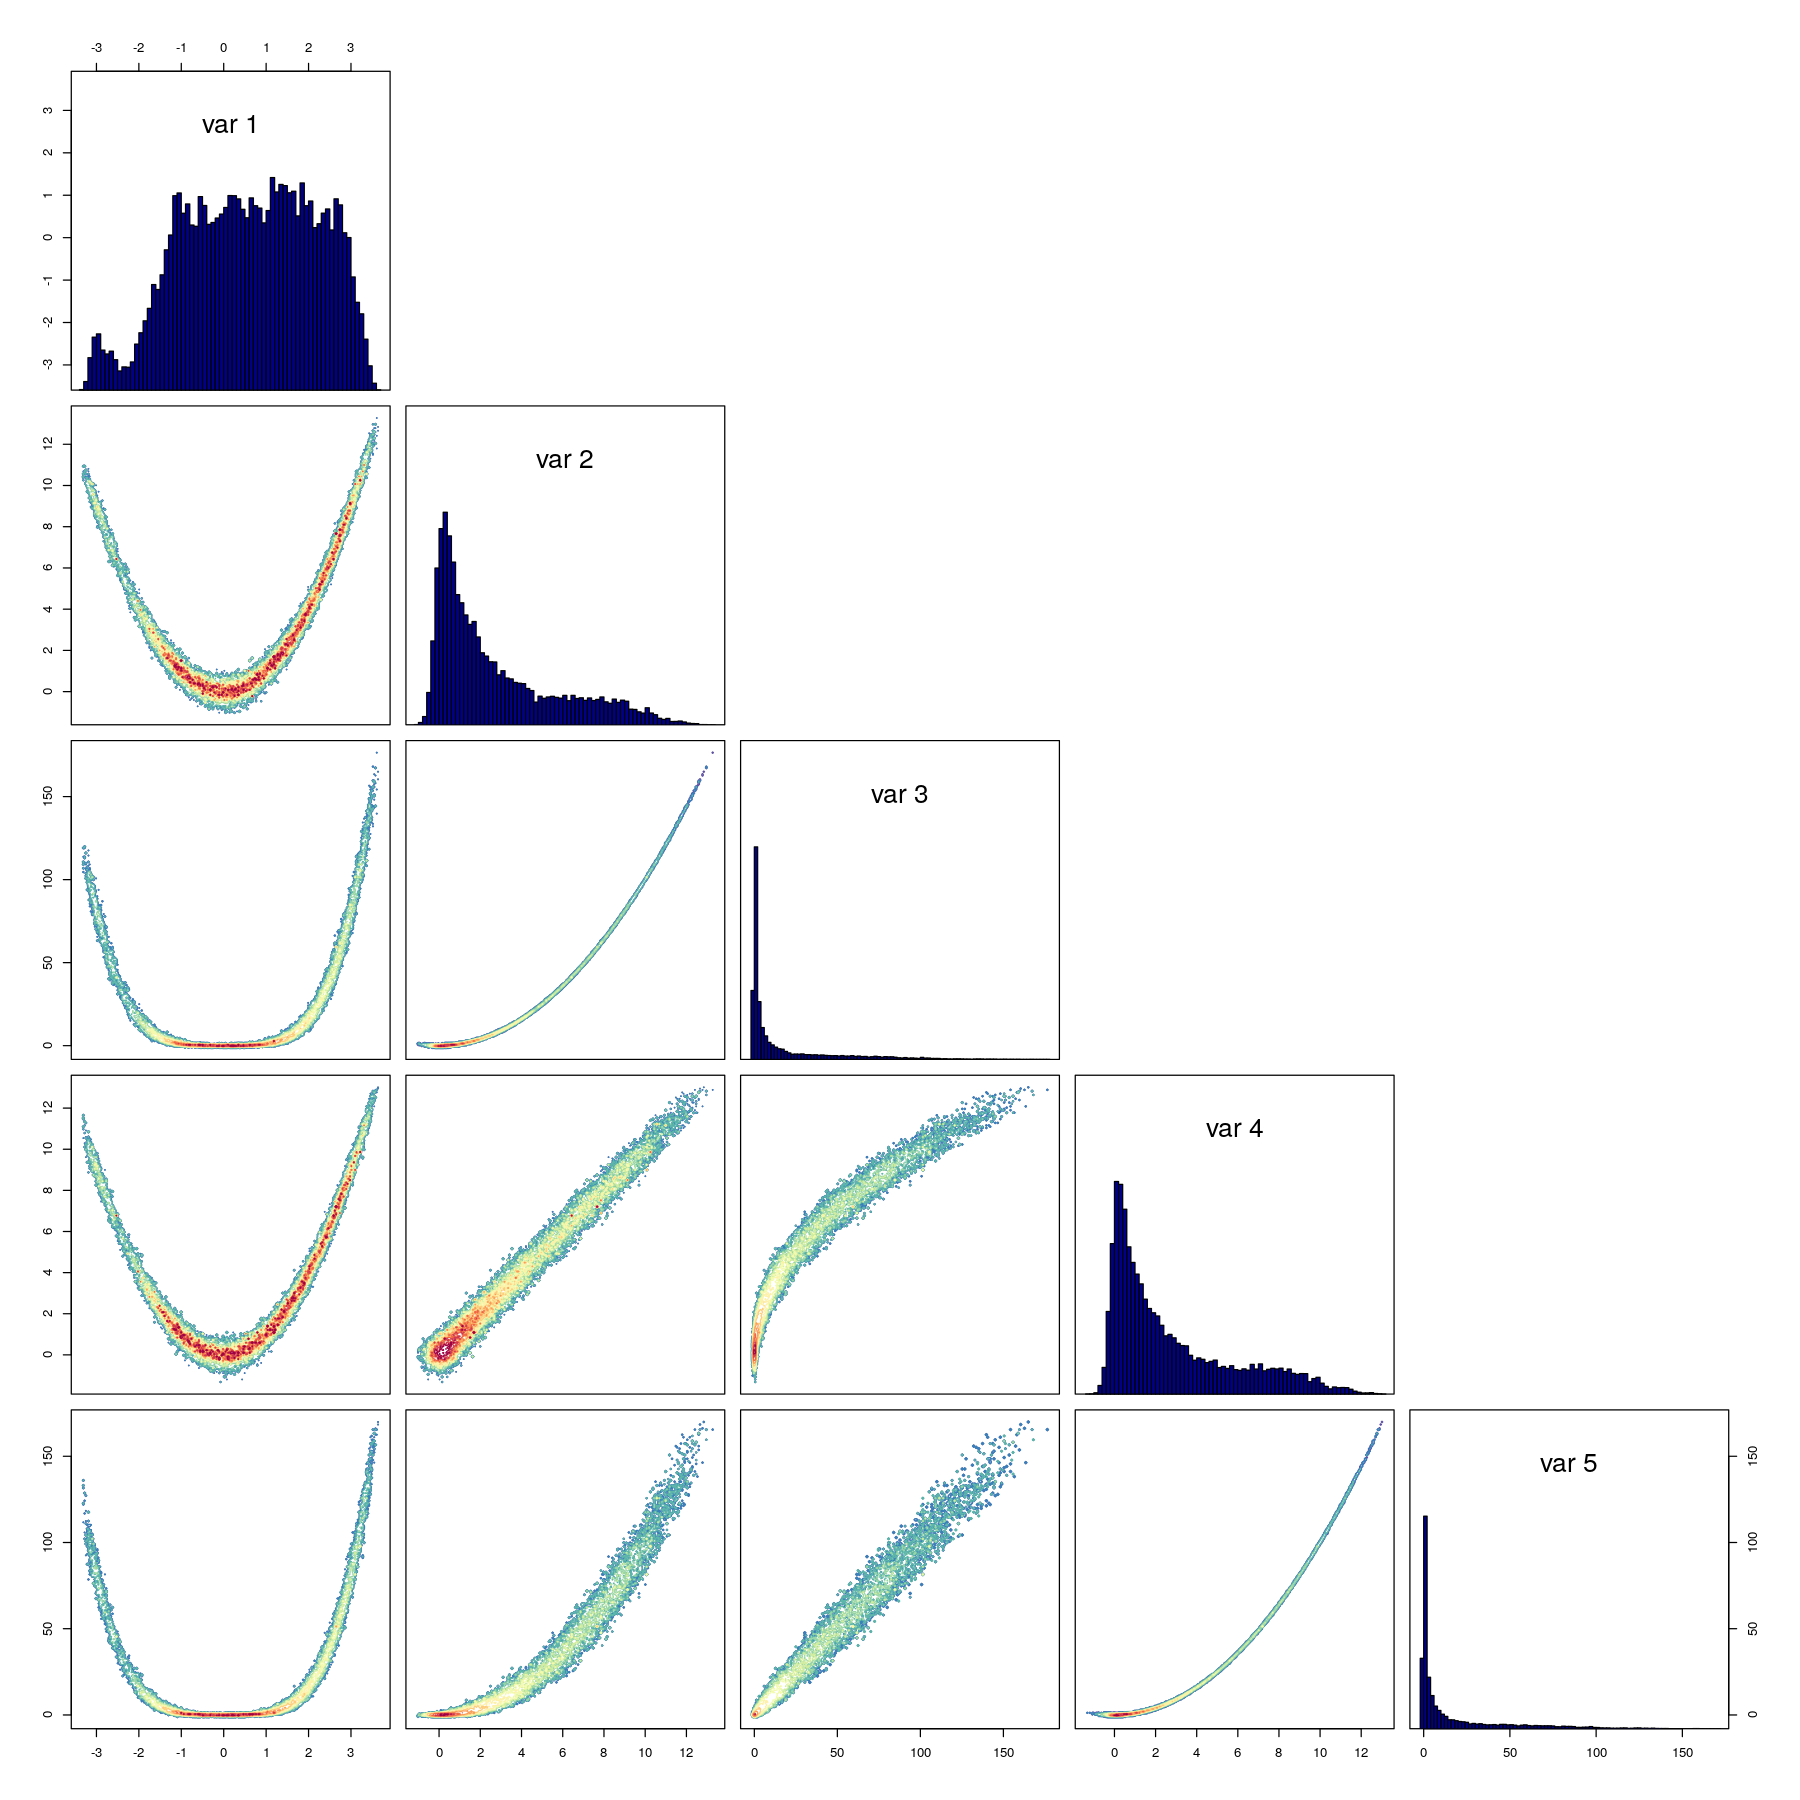

In [79]:
myBetterPairs(resMALA[[1]], resol=.1 ) #plot. Careful not to under- or over-smooth.

## 5) Stan (No-U-Turn-Sampler) [basically smart HMC]

The NUTS algorithm is a smarter version of HMC, where the number of steps per iteration is picked adaptively according to the current trajectory across the target. It basically requires no tuning in all but the most complicated situations. 

Unlike sMMALA, it does not use the local curvature of the target to inform moves, but because of the way the integrator at the core of the algorithm works, it's very flexible.

In [90]:
#### Stan (NUTS, HMC) ####

#this is how you pass a model like this to stan. 
#the *data* block containes fixed quantities, in our case our parameters.
#the parameters block contains the things you want to estimate, in our case the components of the densitiy.
#in the model block, I had to pass our model as a custom one. Standard one are already coded in Stan.

scode = "
data {
  real mu;
  real<lower=0> a;
  real<lower=0> b;
}
parameters {
  vector[5] y;
}
model {
  target += -( a*(y[1]-mu)^2 + b*(y[2] - y[1]^2)^2 + b*(y[3] - y[2]^2)^2 + b*(y[4] - y[1]^2)^2 + b*(y[5] - y[4]^2)^2 ); //Nasty
}"

#registerDoMC(cores=8); getDoParWorkers();
fit1 <- stan( model_code = scode, 
           data=list(mu=1, a=1/20, b=100/20), #need to specify parameters here!!
           iter = 20000,
           chains=4, #need to set up cores for parallel separately 
           cores=4, 
           refresh=0, #turn off comments
           verbose=TRUE,
           init=1, 
           algorithm = "NUTS", 
           control=list(metric="diag_e", adapt_delta=.98, max_treedepth=10)
           )

#The warning messages are very useful, but don't worry too much now, 
#because we know the solution and we know that it's a very difficult target. 


TRANSLATING MODEL '589e32fd02a8a7efc4b8abaf8ebe31eb' FROM Stan CODE TO C++ CODE NOW.
successful in parsing the Stan model '589e32fd02a8a7efc4b8abaf8ebe31eb'.

CHECKING DATA AND PREPROCESSING FOR MODEL '589e32fd02a8a7efc4b8abaf8ebe31eb' NOW.

COMPILING MODEL '589e32fd02a8a7efc4b8abaf8ebe31eb' NOW.

STARTING SAMPLER FOR MODEL '589e32fd02a8a7efc4b8abaf8ebe31eb' NOW.


Warning message:
“There were 362 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 63903 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 1.2, indicating chains have not mixed.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may 

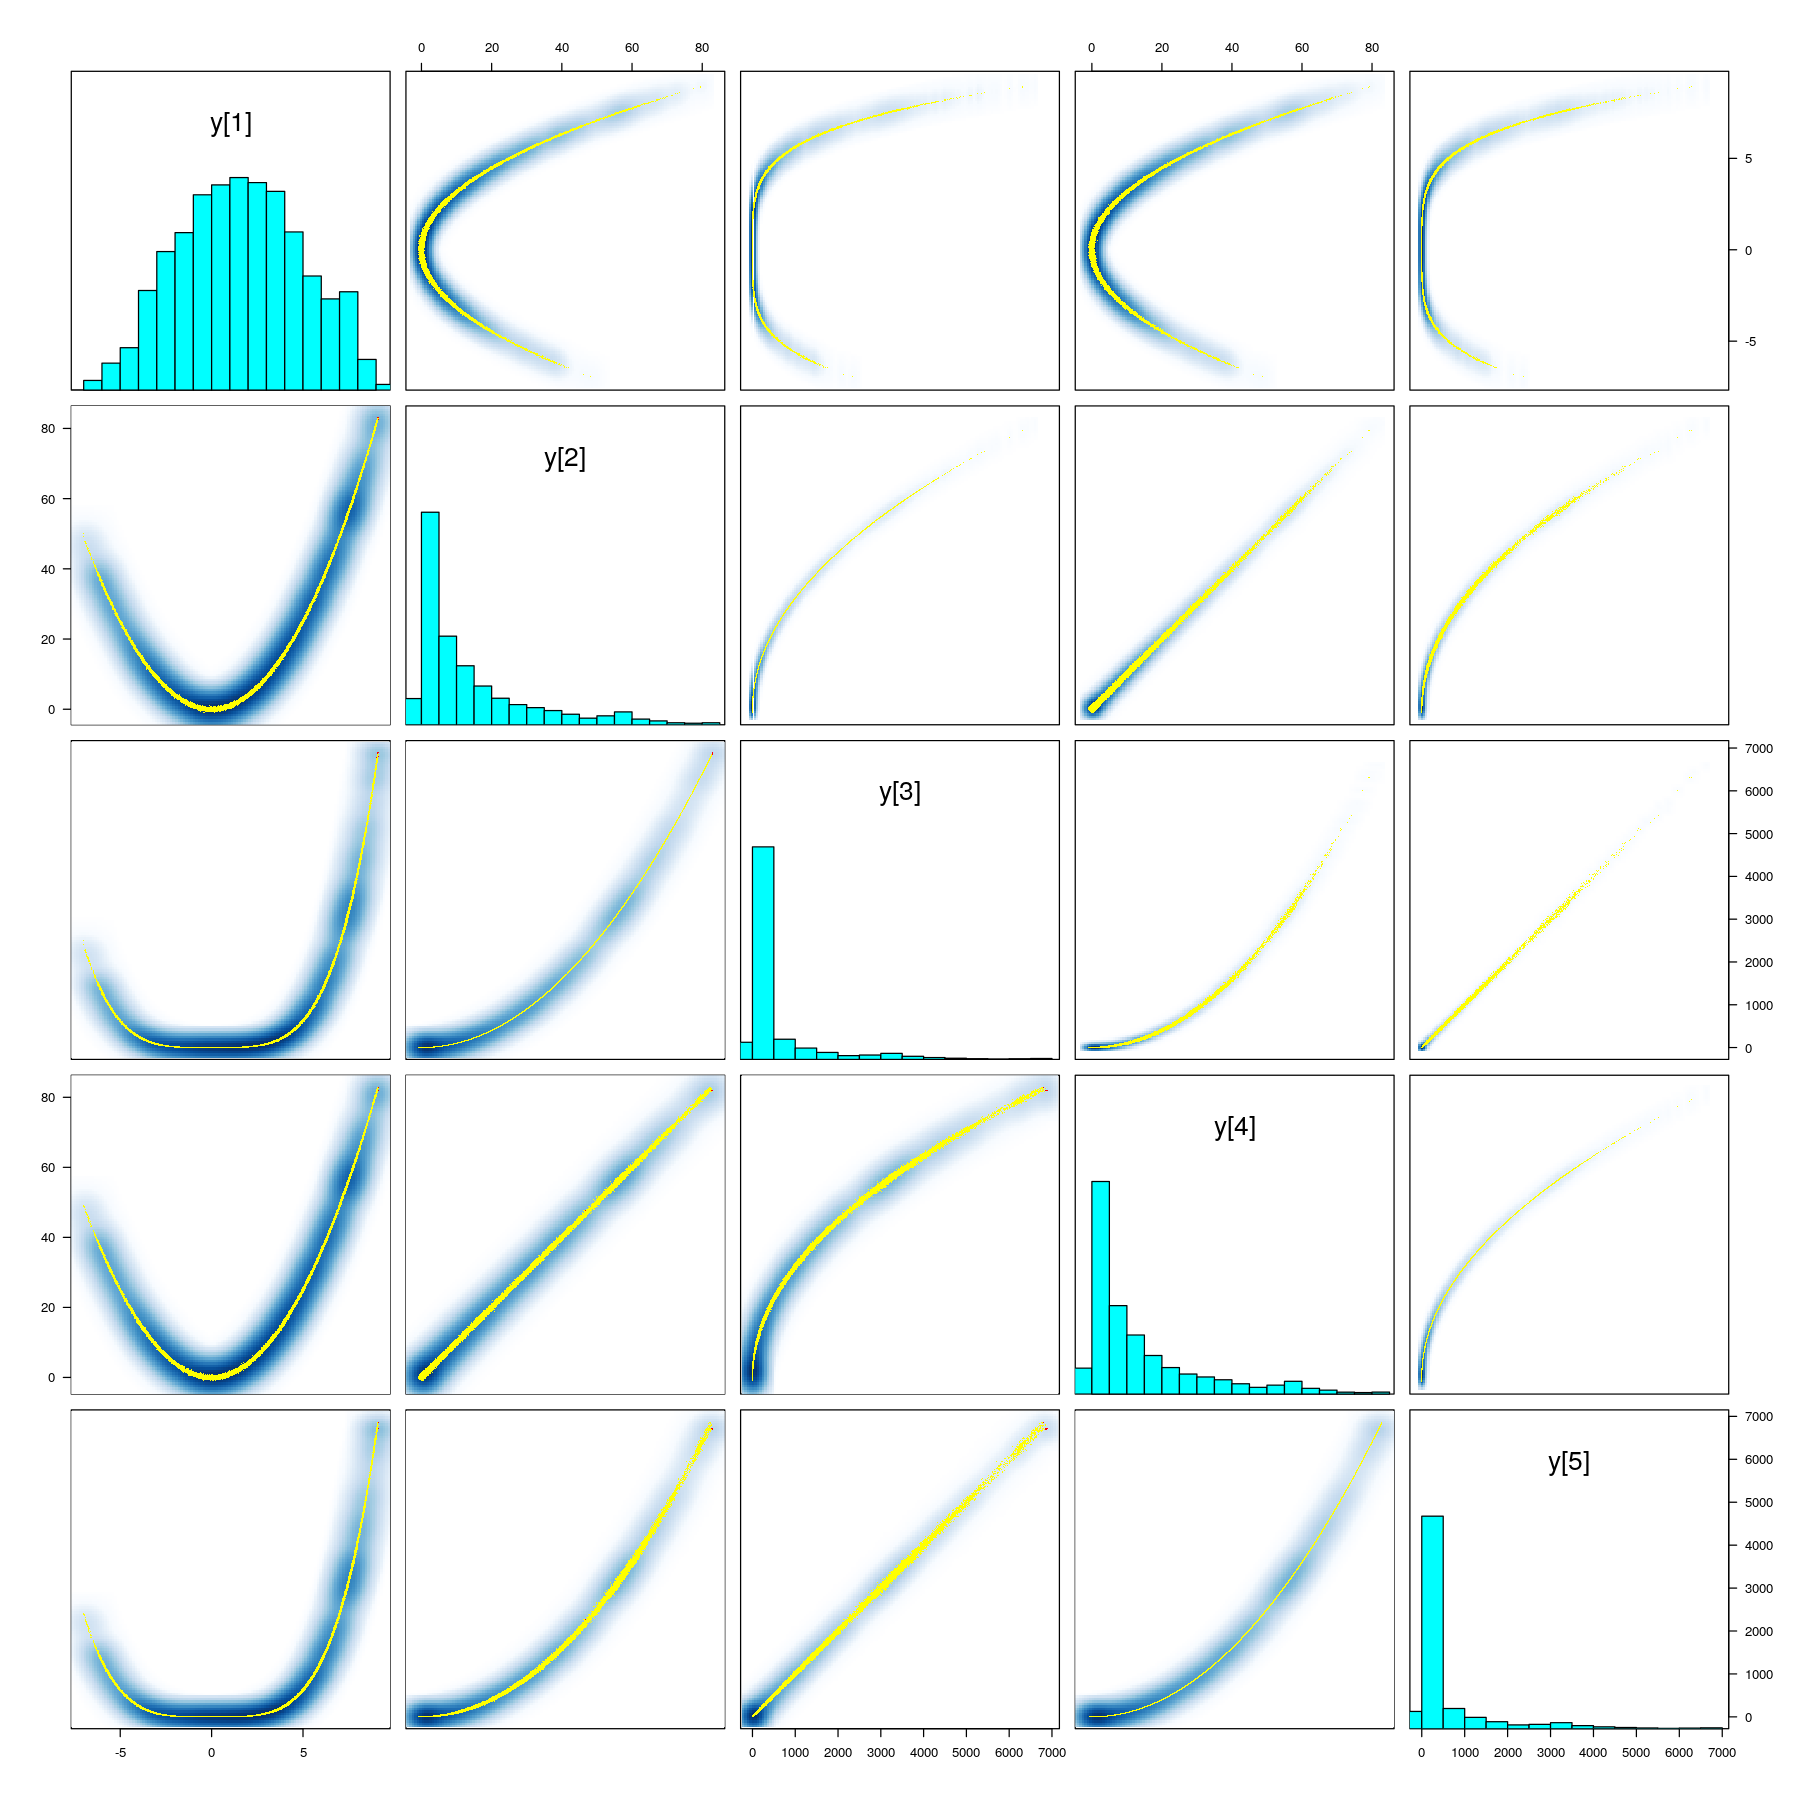

In [91]:
pairs(fit1, pars = c("y"), las = 1) #pairs() function is overloaded for a stan fit object.

## these are other useful functions ##
#e <- extract(fit1) # return a list of arrays
#print(names(e))
#sampler_params <- get_sampler_params(fit1, inc_warmup = FALSE)

Stan does automatic differenciation, and the default settings are farly good.

If it's hard to write your model in the Stan syntax, and/or it's hard to derive the gradient and Hessian (even for Stan sometimes), then you have a problem.

What you can do is 
1. take the Hybrid Rosenbrock distribution 
2. tweak the shape as showed in the initial part of the notebook, to make it similar to the shape of your problem
3. run your favourite MCMC method on it
4. see how biased the results are
5. *either* tell the reviewers that you've checked and it's ok, *or* move on to a more advanced algorithm.